# Graphes générés

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random

from IPython.display import Image
from functools import reduce

## 1. Introduction

Pour ce notebook, nous allons nous intéresser à un modèle de génération de graphes de Git mis au point à Caen.

En particulier, nous allons regarder les mêmes caractéristiques que nous avions étudié sur les graphes de projets GitHub. Nous pourrons ensuite les comparer avec la réalité pour déterminer si ce modèle se rapproche ou non de nos graphes extraits.

Nous avons à notre disposition deux modèles de génération pour les graphes. Le plus intéressant des deux est le second : la labeled-main distribution, et plus particulièrement le générateur de Boltzmann. La particularité de ce modèle réside dans sa capacité à générer des graphes aux formes plus variées, tout en permettant de contrôler le nombre de nœuds appartenant à la branche main. (**pour plus de détails sur le modèle et l'algorithme, voir la partie Références du fichier README.md du git**).

Nous avons généré au préalable 100 graphes allant de 100 à 2000 sur lesquels nous allons mener nos analyses. Nous allons nommer nos graphes de la manière suivante : 

**gen$i$_$n$** avec **$i$** le numéro du graphe et **$n$** le nombre de nœuds du graphe. Par exemple : gen0_1117 est le graphe 0 ayant 1117 nœuds.

Voici un exemple de graphe généré par ce modèle (en rouge, la branche main):

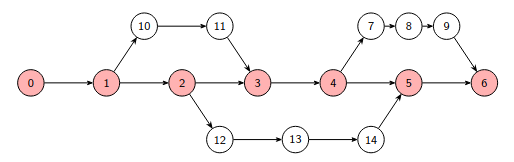

In [2]:
Image("Images/DAGGen_ex.png")

## 2. Comparaison en moyenne de Git et Golden Bisect

Commençons par reprendre l’analyse de la complexité moyenne de Git et de Golden Bisect, mais cette fois-ci appliquée aux graphes générés. Nous allons utiliser la même méthode que celle employée pour les graphes de Git avec les arbres binaires.

Pour rappel, on calcule la moyenne des hauteurs des branches de l’arbre afin d’estimer le nombre moyen de requêtes. 

Notons toutefois une différence importante avec les graphes Git : la méthode de génération utilisée ne permet pas d’obtenir plus d’une seule feuille (celle de la branche main). En effet, comme toutes les branches secondaires sont toujours reliées à deux nœuds de la branche main, elles sont nécessairement fusionnées avant la fin de cette dernière, ce qui conduit à un graphe ne comportant qu’une seule feuille.

Ainsi, contrairement aux graphes Git où l’on obtenait un arbre par feuille du graphe, un graphe généré ne produira qu’un seul arbre.

En appliquant notre méthode aux graphes générés, voici les résultats que l'on obtient :

In [5]:
df_bisect = pd.read_csv('CSV/GenDAGCaen/stats_bisect_gen_caen.csv')
df_bisect

File name  Nodes count  AVG Git  AVG Golden  AVG Golden used  \
0     gen0_1117.tdag         1113  10.1689     10.1689             98.0   
1    gen100_307.tdag          307   8.3322      8.3322             42.0   
2    gen10_1770.tdag         1767  10.8546     10.8546            227.0   
3     gen1_1518.tdag         1510  10.6470     10.6470            274.0   
4     gen11_913.tdag          910   9.8989      9.8989            115.0   
..               ...          ...      ...         ...              ...   
96    gen96_553.tdag          548   9.1533      9.1533             58.0   
97   gen97_1520.tdag         1515  10.6515     10.6515            275.0   
98     gen9_789.tdag          788   9.7081      9.7081            142.0   
99   gen98_1239.tdag         1236  10.3430     10.3430            144.0   
100  gen99_1542.tdag         1536  10.6693     10.6693            268.0   

     AVG nodes differences between golden/git  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   
..                                        ...   
96                                        0.0   
97                                        0.0   
98                                        0.0   
99                                        0.0   
100                                       0.0   

     nodes differences between golden/git  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  
..                                    ...  
96                                      0  
97                                      0  
98                                      0  
99                                      0  
100                                     0  

[101 rows x 7 columns]

Pour rappel, voici la signification des colonnes : 
- File name est le nom du graphe
- Nodes count, le nombre de noeuds dans le graphe
- AVG Git et AVG Golden, le nombre de requêtes en moyenne calculé avec les arbres pour Git et Golden Bisect
- AVG Golden used, le nombre de fois où on utilise la comparaison spécifique de Golden Bisect au lieu de la comparaison classique de Git Bisect
- AVG nodes differences between golden/git, le nombre de noeuds différents en moyenne dans les arbres produits pour Git et Golden
- nodes differences between golden/git, le nombre de noeuds différents entre les arbres produits pour Git et Golden

De la même manière qu’avec les graphes Git, on constate que les moyennes calculées sont exactement les mêmes pour Git et Golden Bisect. Cependant, on remarque cette fois-ci que les arbres produits par les deux algorithmes sont identiques pour chaque graphe, sachant qu’il n’y a qu’un seul arbre par graphe. Faisons une recherche dans le CSV pour en être sûr.

In [6]:
print("Graphes avec des arbres différents entre Git et Golden Bisect :")
cond = df_bisect["nodes differences between golden/git"] > 0
df_bisect[cond]

Graphes avec des arbres différents entre Git et Golden Bisect :


Empty DataFrame
Columns: [File name, Nodes count, AVG Git, AVG Golden, AVG Golden used, AVG nodes differences between golden/git, nodes differences between golden/git]
Index: []

On constate donc que pour chaque graphe, les arbres sont identiques.

Ce phénomène s’explique par la structure particulière des graphes générés. En effet, la méthode utilisée impose qu’une branche secondaire ne puisse pas engendrer de nouvelle branche à partir de l’un de ses nœuds. De plus, comme Git et Golden Bisect reposent sur un principe proche de la dichotomie, ils cherchent à sélectionner le nœud central à chaque étape. Ainsi, la structure simplifiée des graphes limite fortement les choix possibles pour les deux algorithmes, ce qui conduit à la production d’arbres identiques.

On peut donc en déduire que Git et Golden Bisect se comportent de manière équivalente sur les graphes générés comme sur les graphes extraits de projets Git. Cependant, les deux algorithmes suivent exactement les même étapes.

## 2. Structure des graphes et statistiques générales

A présent, on va regarder la structure générale des graphes générés tout comme on l'avait fait avec les graphes de Git.

### a. Premères observations

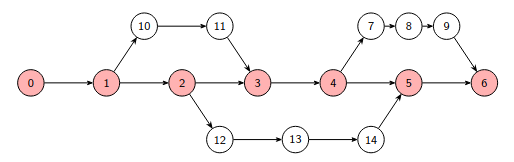

In [7]:
Image("Images/DAGGen_ex.png")

On le voit tout de suite sur cet exemple et on l'avait aussi mentionné dans la partie précédente, mais une branche secondaire ne peut pas partir d'une autre branche secondaire dans ce modèle. En effet, l'algorithme utilisé impose cette structure (**Voir référence dans le README.md**) avec en plus la présence d'une unique feuille dans chaque graphe contrairement aux graphes de Git.

C'est une différence majeure de la structure mais nous allons creuser un peu plus sur les nœuds.

### b. Statistiques sur les enfants

Pour les prochaines sous-parties, on va se baser sur deux CSV **stats_enfants_gen_caen.csv** et **stats_parents_gen_caen.csv** qui contiennent les colonnes :
- File name : le nom du fichier.
- Nodes count : le nombre de noeuds du graphe.
- Leaves count et % leaves : le nombre de feuilles du graphe et sa proportion dans le graphe. 
- 1 child, n childrens (ou parents), % 1 child et % n childrens (ou parents): le nombre de noeuds à $n$ enfants (ou parents) et leur proportion dans le graphe.
- P(X=n)/P(X=n-1) : le ratio entre le nombre de noeuds à n enfants et le nombre de noeuds à n-1 enfants. On va s'enservir pour détecter de nouveau une loi géométrique.
- More than 30 et % More than 30 : le nombre de noeuds à plus de 30 enfants car certains graphes on des noeuds à plus de 30 enfants mais cela reste des cas isolés.

Observons d'abord les enfants des nœuds :

In [8]:
df_enf = pd.read_csv('CSV/GenDAGCaen/stats_enfants_gen_caen.csv').dropna(axis=1)
df_enf

File name  Nodes count  Leaves count  % leaves  1 child  \
0     gen0_1117.tdag         1113             1    0.0898      846   
1    gen100_307.tdag          307             1    0.3257      232   
2    gen10_1770.tdag         1767             1    0.0566     1330   
3     gen1_1518.tdag         1510             1    0.0662     1142   
4     gen11_913.tdag          910             1    0.1099      689   
..               ...          ...           ...       ...      ...   
96    gen96_553.tdag          548             1    0.1825      410   
97   gen97_1520.tdag         1515             1    0.0660     1146   
98     gen9_789.tdag          788             1    0.1269      592   
99   gen98_1239.tdag         1236             1    0.0809      941   
100  gen99_1542.tdag         1536             1    0.0651     1147   

     2 childrens  3 childrens  4 childrens  5 childrens  6 childrens  ...  \
0            131           67           42           19            7  ...   
1             38           20           10            5            1  ...   
2            224          118           55           22            8  ...   
3            190           87           55           16            9  ...   
4            106           64           31           14            2  ...   
..           ...          ...          ...          ...          ...  ...   
96            75           40            8            7            4  ...   
97           194           87           43           31            4  ...   
98           106           45           25           12            4  ...   
99           153           66           40           22            6  ...   
100          220           85           46           18            6  ...   

     % 22 childrens  % 23 childrens  % 24 childrens  % 25 childrens  \
0               0.0             0.0             0.0             0.0   
1               0.0             0.0             0.0             0.0   
2               0.0             0.0             0.0             0.0   
3               0.0             0.0             0.0             0.0   
4               0.0             0.0             0.0             0.0   
..              ...             ...             ...             ...   
96              0.0             0.0             0.0             0.0   
97              0.0             0.0             0.0             0.0   
98              0.0             0.0             0.0             0.0   
99              0.0             0.0             0.0             0.0   
100             0.0             0.0             0.0             0.0   

     % 26 childrens  % 27 childrens  % 28 childrens  % 29 childrens  \
0               0.0             0.0             0.0             0.0   
1               0.0             0.0             0.0             0.0   
2               0.0             0.0             0.0             0.0   
3               0.0             0.0             0.0             0.0   
4               0.0             0.0             0.0             0.0   
..              ...             ...             ...             ...   
96              0.0             0.0             0.0             0.0   
97              0.0             0.0             0.0             0.0   
98              0.0             0.0             0.0             0.0   
99              0.0             0.0             0.0             0.0   
100             0.0             0.0             0.0             0.0   

     % 30 childrens  % More than 30  
0               0.0             0.0  
1               0.0             0.0  
2               0.0             0.0  
3               0.0             0.0  
4               0.0             0.0  
..              ...             ...  
96              0.0             0.0  
97              0.0             0.0  
98              0.0             0.0  
99              0.0             0.0  
100             0.0             0.0  

[101 rows x 95 columns]

Regardons comment se répartissent les noeuds à $n$ enfants.

In [9]:
def create_index(df):
    index = dict()
    for idx, row in df.iterrows():
        index[row["File name"]] = idx
    return index

index = create_index(df_enf)

In [16]:
def random_graphs(k, df):
    return list(random.sample(list(df["File name"]), k=k))

def draw_histo_c(graph_name, df, num):
    line = df[df['File name'] == graph_name].iloc[0]
    col_range = ["1 child"]
    col_range.extend([f"{i} childrens" for i in range(2, 31)])
    col_range.append("More than 30")
    available_cols = [col for col in col_range if col in df.columns]
    val = line[available_cols]
    plt.figure(figsize=(10, 5))
    val.plot(kind='bar')
    plt.title(f'[{num}] {graph_name}')
    plt.xlabel("Nombre d'enfants")
    plt.ylabel('Fréqeunce de noeuds')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

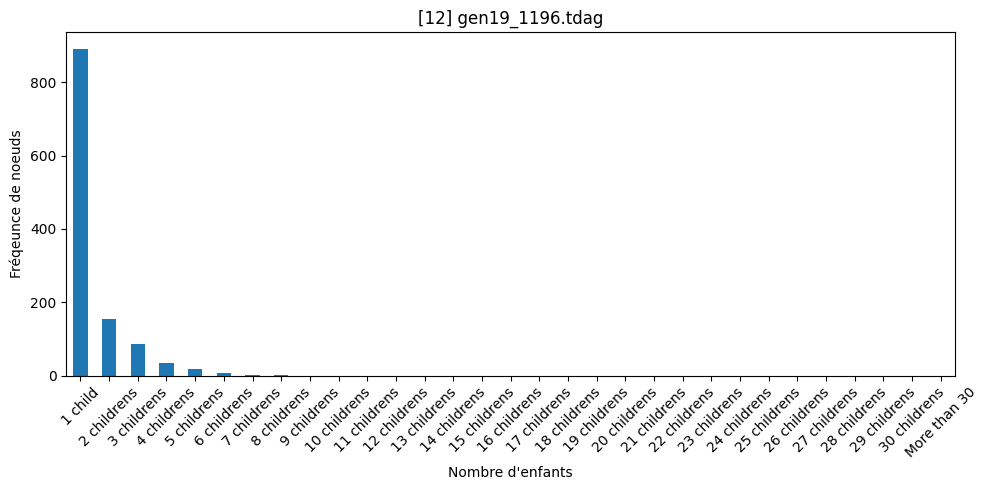

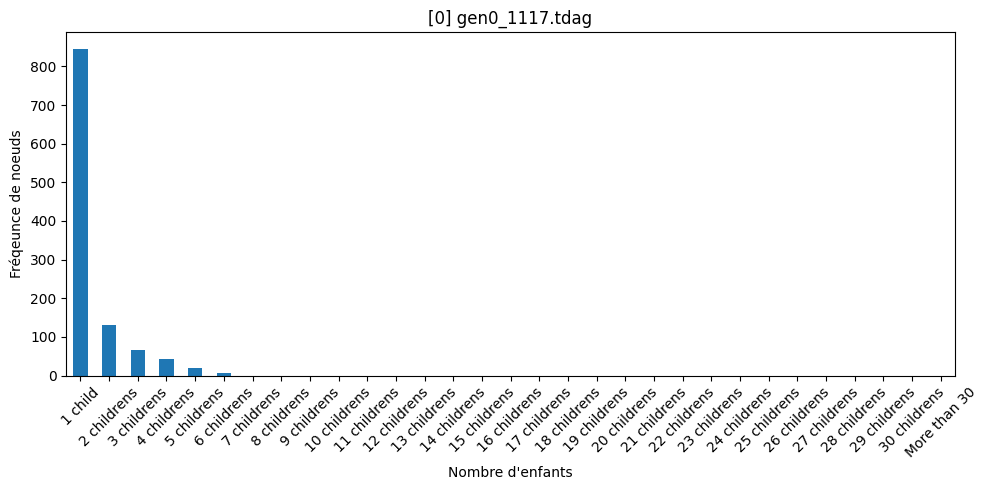

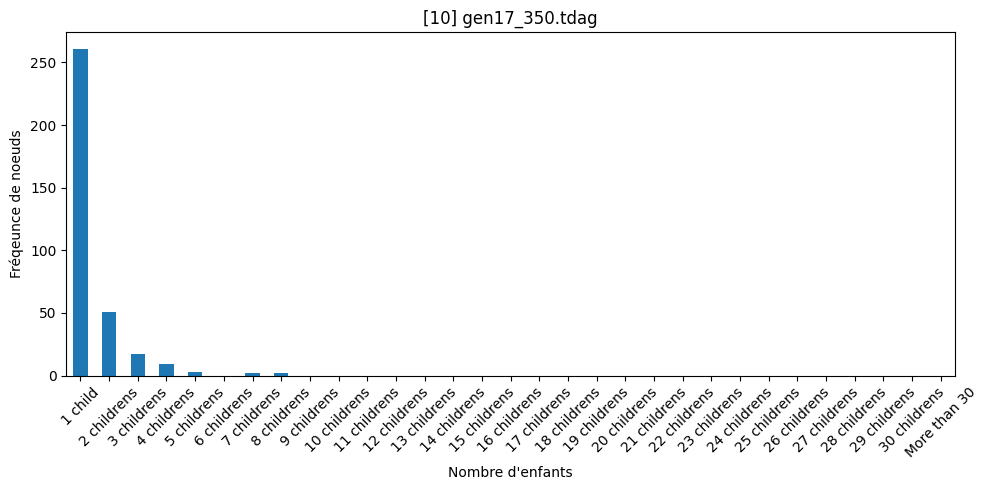

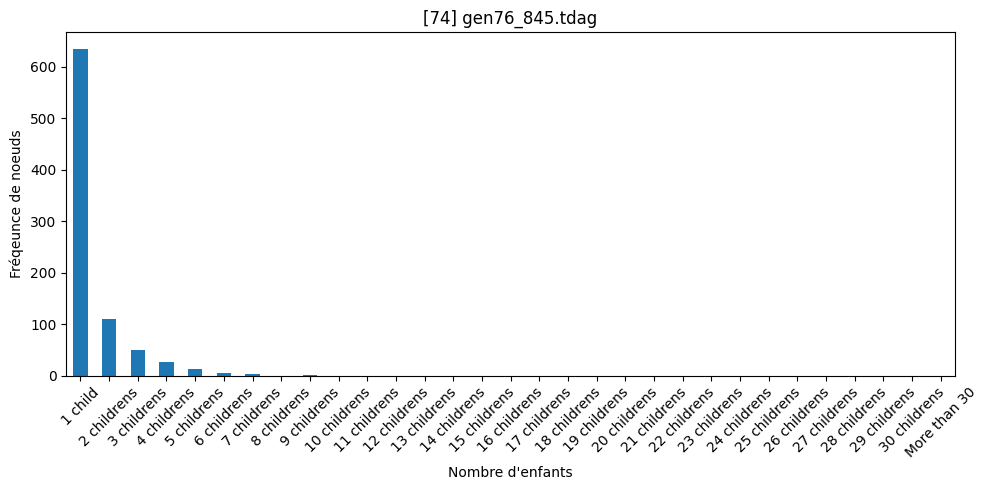

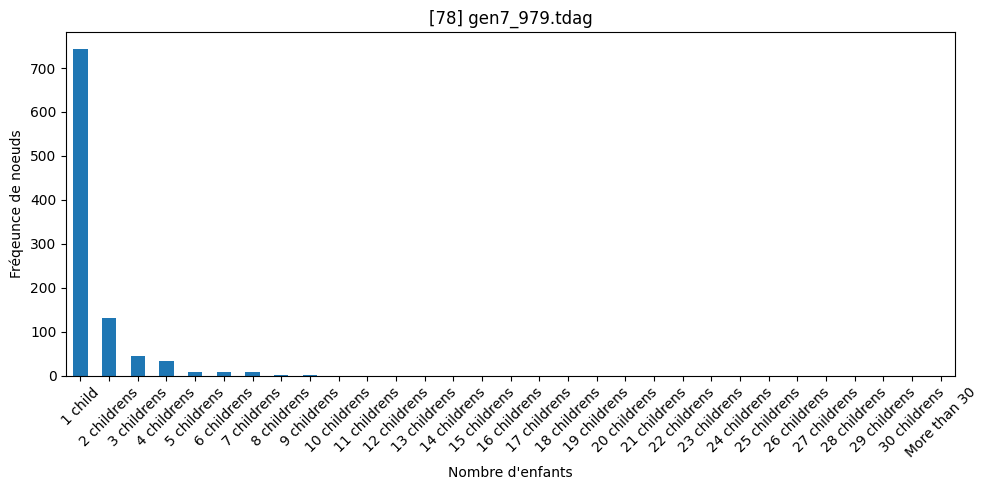

In [18]:
for name in random_graphs(5, df_enf):
    draw_histo_c(name, df_enf, index[name])

En prennant 5 graphes aléatoirement, on remarque que la plupart des noeuds ont en majorité 1 enfant et sinon de 2 à 6. Le reste est très minime. C'est assez similaire à ce que l'on avait observé sur les graphes de Git.

Nous allons maintenant faire la moyenne des proportions et comparer avec ce que l'on avait sur les graphes de Git.

In [24]:
def generate_prop_c(df_c):
    cols_c = ["% leaves", "% 1 child"]
    cols_c.extend([f"% {i} childrens" for i in range(2, 30)])
    cols_c.append("% More than 30")

    prob_c = [df_c[col].mean() for col in cols_c]
                 
    caract = [name.removeprefix("% ") for name in cols_c]
    caract[0] = "leaf"
    probabilities = prob_c
    proportion = [p/100 for p in prob_c]

    df = pd.DataFrame({
        "Caract": caract,
        "Probability (%)": probabilities,
        "Proportion" : proportion
    })

    return df

def merge_df(**dfs):
    dfs_renamed = []
    for name, df in dfs.items():
        renamed = df.rename(columns={
            "Probability (%)": f"Probability_{name} (%)",
            "Proportion": f"Proportion_{name}"
        })
        dfs_renamed.append(renamed)
    return reduce(lambda left, right: pd.merge(left, right, on="Caract"), dfs_renamed)

In [28]:
df_enf_git = pd.read_csv('CSV/GitDAG/stats_enfants.csv').dropna(axis=1)
merge_df(git=generate_prop_c(df_enf_git), gen=generate_prop_c(df_enf))

Caract  Probability_git (%)  Proportion_git  Probability_gen (%)  \
0           leaf            12.757305        0.127573             0.142497   
1        1 child            75.219585        0.752196            75.537411   
2    2 childrens             6.893395        0.068934            12.798377   
3    3 childrens             2.308890        0.023089             6.175081   
4    4 childrens             1.127482        0.011275             2.991235   
5    5 childrens             0.625511        0.006255             1.389987   
6    6 childrens             0.368789        0.003688             0.584671   
7    7 childrens             0.216154        0.002162             0.235318   
8    8 childrens             0.139359        0.001394             0.099789   
9    9 childrens             0.090524        0.000905             0.029464   
10  10 childrens             0.062676        0.000627             0.011484   
11  11 childrens             0.045141        0.000451             0.004705   
12  12 childrens             0.031158        0.000312             0.000000   
13  13 childrens             0.023486        0.000235             0.000000   
14  14 childrens             0.016551        0.000166             0.000000   
15  15 childrens             0.012978        0.000130             0.000000   
16  16 childrens             0.009568        0.000096             0.000000   
17  17 childrens             0.007940        0.000079             0.000000   
18  18 childrens             0.006933        0.000069             0.000000   
19  19 childrens             0.004539        0.000045             0.000000   
20  20 childrens             0.004236        0.000042             0.000000   
21  21 childrens             0.003485        0.000035             0.000000   
22  22 childrens             0.002357        0.000024             0.000000   
23  23 childrens             0.002240        0.000022             0.000000   
24  24 childrens             0.002026        0.000020             0.000000   
25  25 childrens             0.001714        0.000017             0.000000   
26  26 childrens             0.001586        0.000016             0.000000   
27  27 childrens             0.000863        0.000009             0.000000   
28  28 childrens             0.000975        0.000010             0.000000   
29  29 childrens             0.000714        0.000007             0.000000   
30  More than 30             0.010928        0.000109             0.000000   

    Proportion_gen  
0         0.001425  
1         0.755374  
2         0.127984  
3         0.061751  
4         0.029912  
5         0.013900  
6         0.005847  
7         0.002353  
8         0.000998  
9         0.000295  
10        0.000115  
11        0.000047  
12        0.000000  
13        0.000000  
14        0.000000  
15        0.000000  
16        0.000000  
17        0.000000  
18        0.000000  
19        0.000000  
20        0.000000  
21        0.000000  
22        0.000000  
23        0.000000  
24        0.000000  
25        0.000000  
26        0.000000  
27        0.000000  
28        0.000000  
29        0.000000  
30        0.000000

A gauche, on a les probabilité calculées pour les graphes de Git et à droite les graphes générés.

Les probabilités que l'on trouve sont dans le même ordre de grandeur pour les noeuds de 1 à 1à enfants. Cependant, dans les graphes générés, il n'y a aucun noeud à plus de 11 enfants. C'est possiblement lié au fait que les graphes générés ne vont pas au delà de 2000 noeuds.

### c. Statistiques sur les parents

Les statistiques sur les enfants étaient plutôt proches de ce que l'on avait observe. Intéressons nous maintenant aux parents des noeuds.

In [29]:
df_p = pd.read_csv('CSV/GenDAGCaen/stats_parents_gen_caen.csv').dropna(axis=1)
df_p

File name  Nodes count  1 parent  2 parents  3 parents  \
0     gen0_1117.tdag         1113       610        502          0   
1    gen100_307.tdag          307       173        133          0   
2    gen10_1770.tdag         1767       948        818          0   
3     gen1_1518.tdag         1510       805        704          0   
4     gen11_913.tdag          910       497        412          0   
..               ...          ...       ...        ...        ...   
96    gen96_553.tdag          548       302        245          0   
97   gen97_1520.tdag         1515       814        700          0   
98     gen9_789.tdag          788       428        359          0   
99   gen98_1239.tdag         1236       666        569          0   
100  gen99_1542.tdag         1536       823        712          0   

     More than 3  % 1 parent  % 2 parents  % 3 parents  % More than 3  
0              0     54.8068      45.1033          0.0            0.0  
1              0     56.3518      43.3225          0.0            0.0  
2              0     53.6503      46.2932          0.0            0.0  
3              0     53.3113      46.6225          0.0            0.0  
4              0     54.6154      45.2747          0.0            0.0  
..           ...         ...          ...          ...            ...  
96             0     55.1095      44.7080          0.0            0.0  
97             0     53.7294      46.2046          0.0            0.0  
98             0     54.3147      45.5584          0.0            0.0  
99             0     53.8835      46.0356          0.0            0.0  
100            0     53.5807      46.3542          0.0            0.0  

[101 rows x 10 columns]

In [30]:
def draw_histo_p(graph_name, df, num):
    line = df[df['File name'] == graph_name].iloc[0]
    col_range = ["1 parent", "2 parents", "3 parents"]
    available_cols = [col for col in col_range if col in df.columns]
    val = line[available_cols]
    plt.figure(figsize=(10, 5))
    val.plot(kind='bar')
    plt.title(f'[{num}] {graph_name}')
    plt.xlabel('Nombre de parents')
    plt.ylabel('Fréqeunce de noeuds')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

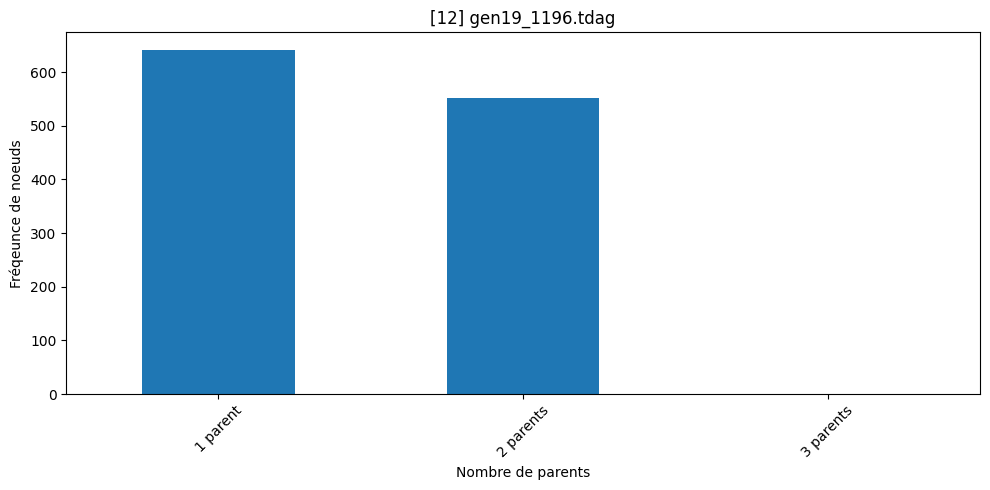

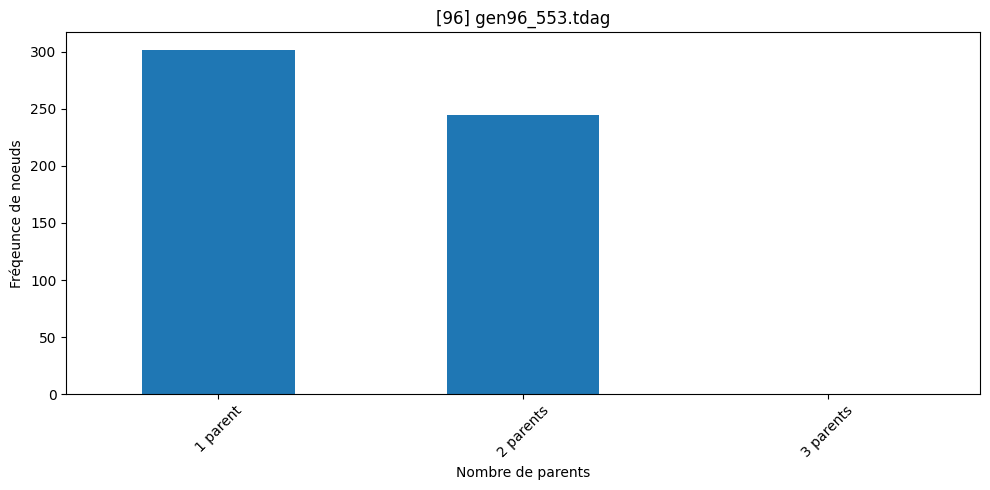

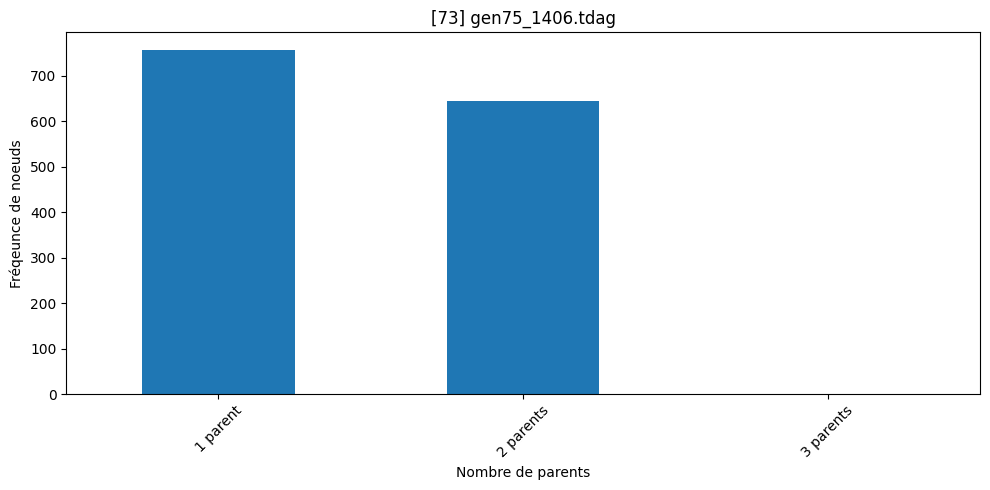

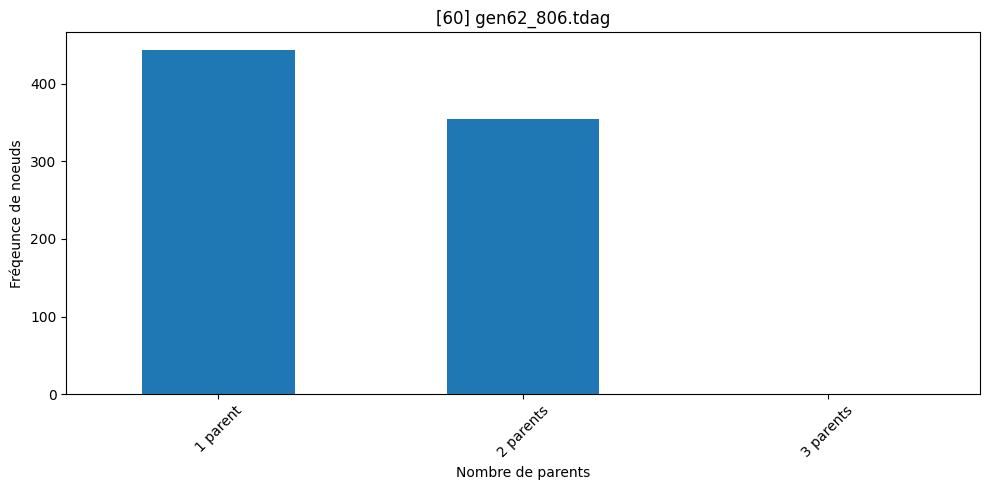

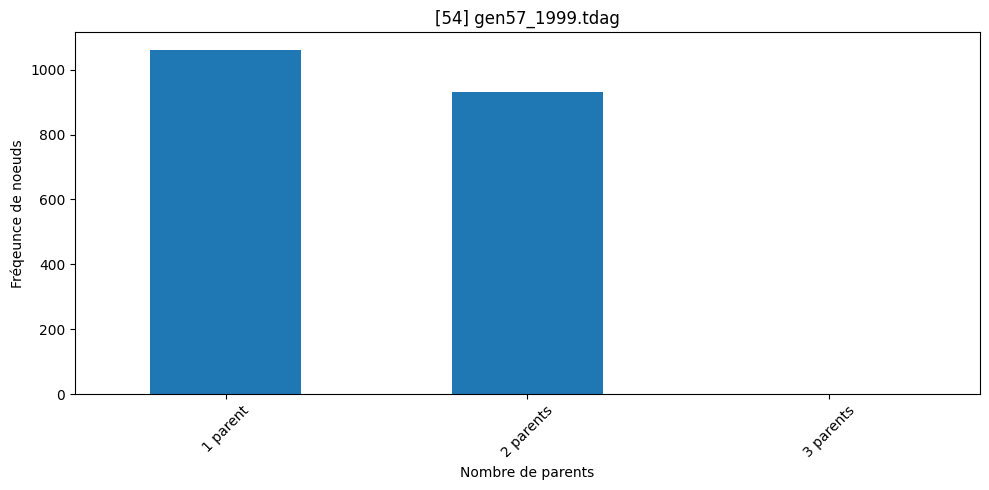

In [31]:
for name in random_graphs(5, df_p):
    draw_histo_p(name, df_p, index[name])

En prenant 5 graphes aléatoires, on observe un différence. En effet, contrairement aux graphes de git qui avaient en majorité des noeuds à un seul parents avec quelques noeuds à deux parents et des neouds à trois parents en minorité, on voit qu'il y a quasiment autant de noeuds à un parent qu'à deux parents ici.

Faison la moyenne des proportions pour confirmer notre intuition.

In [32]:
def generate_prop_p(df_p):
    cols_p = ["% 1 parent", "% 2 parents", "% 3 parents"]
    prob_p = [df_p[col].mean() for col in cols_p]
                 
    caract = [name.removeprefix("% ") for name in cols_p]
    probabilities = prob_p
    proportion = [p/100 for p in prob_p]

    df = pd.DataFrame({
        "Caract": caract,
        "Probability (%)": probabilities,
        "Proportion" : proportion
    })

    return df

In [33]:
df_p_git = pd.read_csv('CSV/GitDAG/stats_parents.csv').dropna(axis=1)
merge_df(git=generate_prop_p(df_p_git), gen=generate_prop_p(df_p))

Caract  Probability_git (%)  Proportion_git  Probability_gen (%)  \
0   1 parent            86.924203        0.869242            54.755449   
1  2 parents            13.055760        0.130558            45.102059   
2  3 parents             0.001016        0.000010             0.000000   

   Proportion_gen  
0        0.547554  
1        0.451021  
2        0.000000

A gauche, on a les probabilités calculées pour les graphes de Git et à droite les graphes générés.

La différence est nette sur les moyennes. Là où on avait une majorité de noeuds à un parent sur les graphes de git, on a quasiment autant de noeuds à un parent qu'à deux parents sur les graphes générés.

Les proportions sur les graphes de git semblaient plus logiques car on ne s'attend pas à faire énormément de fusions de branches dans un projet, or les graphes générés sont éloignés de la réalité ce qui suggère que le modèle n'est peut être pas adéquat.

### d. Loi géométrique

Pour cette dernière sous-partie, on va essayer de détecter la présence d'une loi géométrique d'abors par l'observation des ratios. Pour rappel, on va regader les ratios entre les fréquences de nœuds à n enfants et les fréquences de nœuds à n + 1 enfants, c'est-à-dire que si on note $e_n$ la fréquence de nœuds ayant n enfants alors on va faire $\frac{e_{n + 1}}{e_n}$. 

Pour le faire, on va tracer les ratios sur un graphique, si on remarque une certaine constance sur un groupe de ratios (un groupe d'au moins 7 ratios), cela pourrait suggérer la présence d'une loi géométrique sur ce groupe. On va volontairement tronquer aux noeuds à 11 enfants car on avait vu que les graphes générs n'allaient pas au delà.

In [34]:
all_ratio_cols = [f"P(X={i+1})/P(X={i})" for i in range(1, 30)]
keep_ratio_cols = [f"P(X={i+1})/P(X={i})" for i in range(1, 12)]
drop_cols = list(set(all_ratio_cols) - set(keep_ratio_cols))
df_enf_cleaned = df_enf.drop(columns=drop_cols)
cols = keep_ratio_cols

In [37]:
def plot_ratios(df, ratio_cols, file_col="File name"):
    for idx, row in df.iterrows():
        ratios = row[ratio_cols].values.astype(float)
        x_labels = [f"P{i+1}/P{i}" for i in range(1, len(ratio_cols) + 1)]
        file_name = row[file_col]

        plt.figure(figsize=(10, 5))
        plt.plot(x_labels, ratios, marker='o')
        plt.title(f"[{idx}] – {file_name}")
        plt.xticks(ticks=x_labels, labels=x_labels, rotation=45)
        plt.ylabel("P(X=i+1) / P(X=i)")
        plt.grid(True)
        plt.tight_layout()

/tmp/ipykernel_4615/2555469076.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


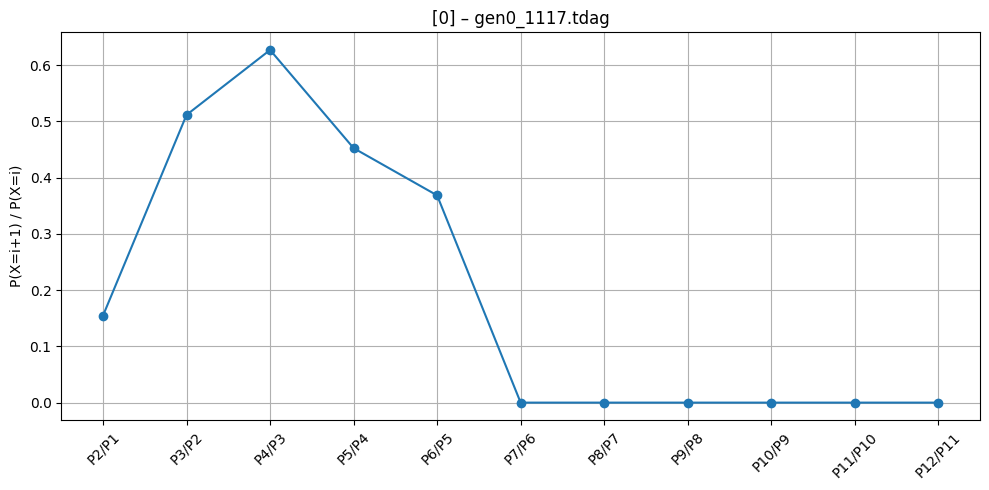

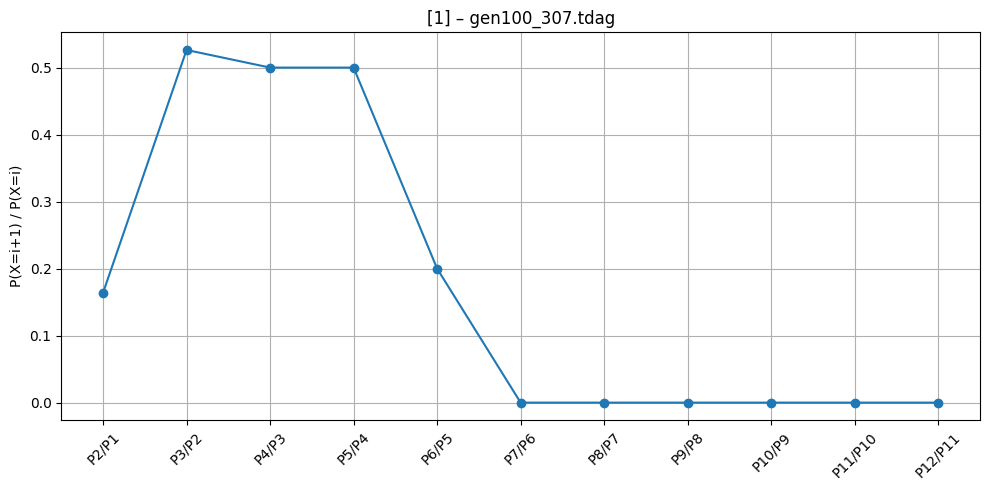

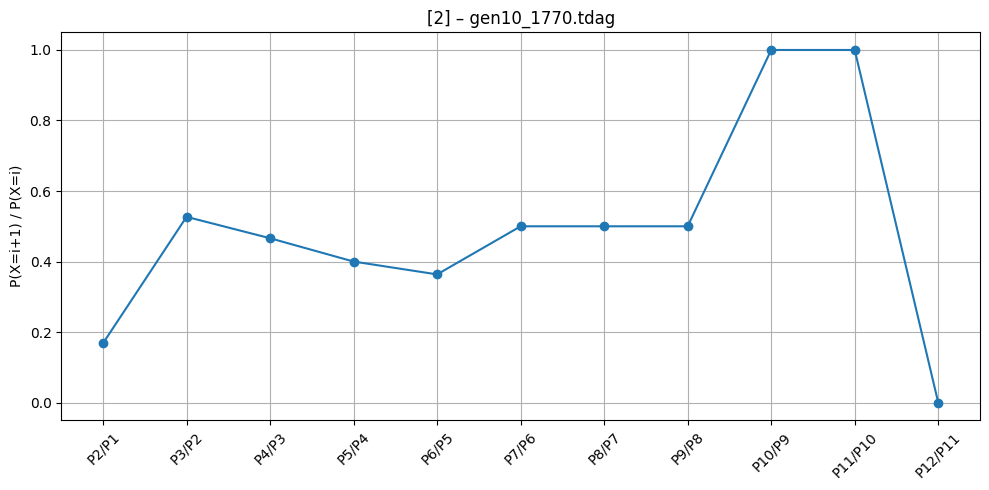

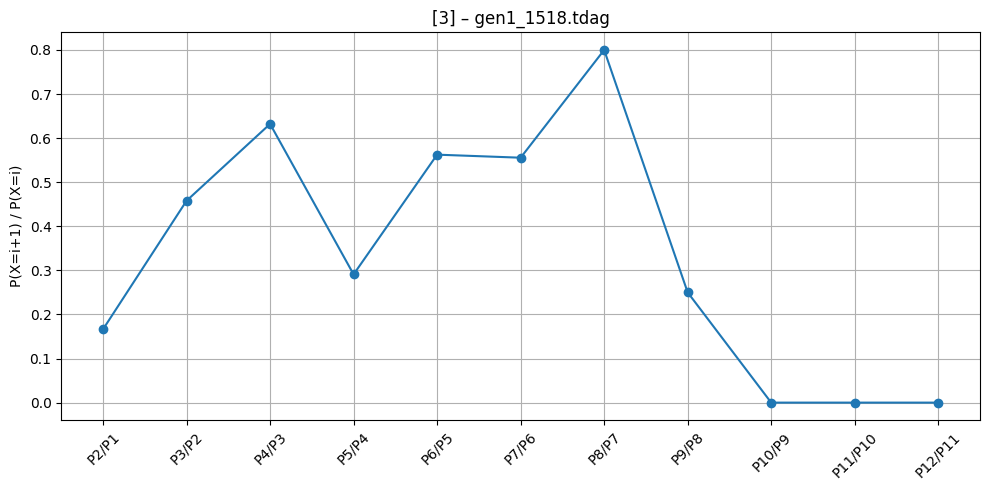

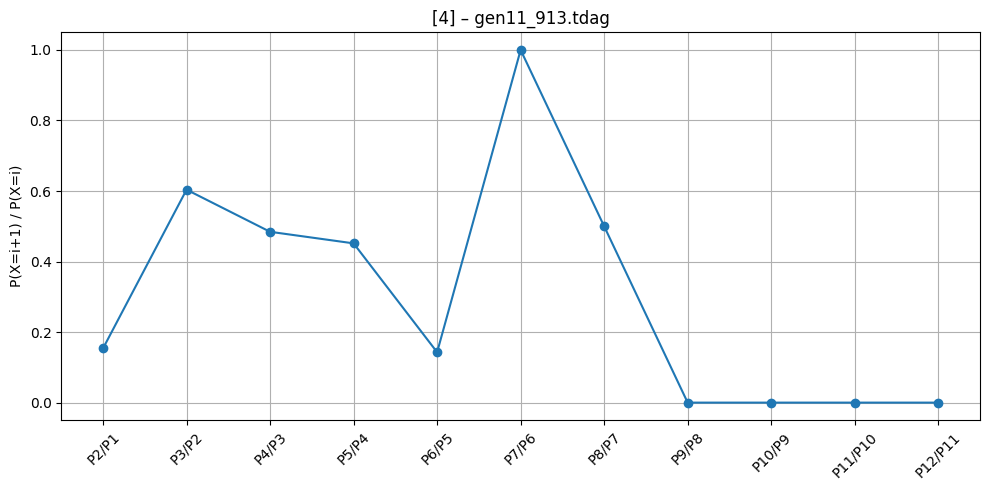

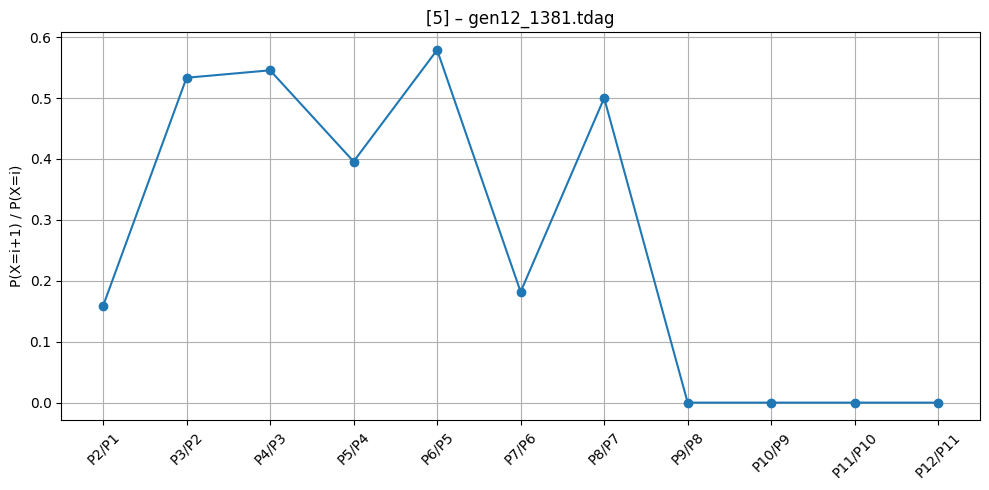

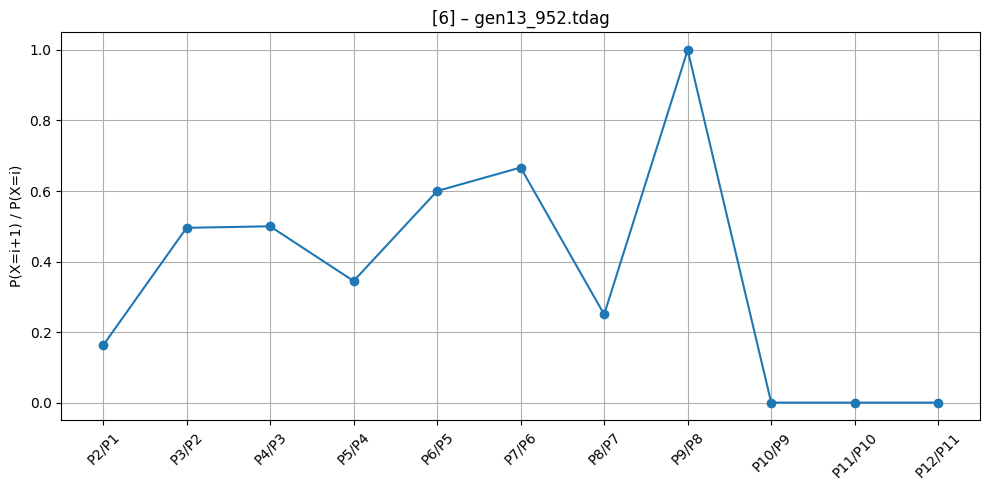

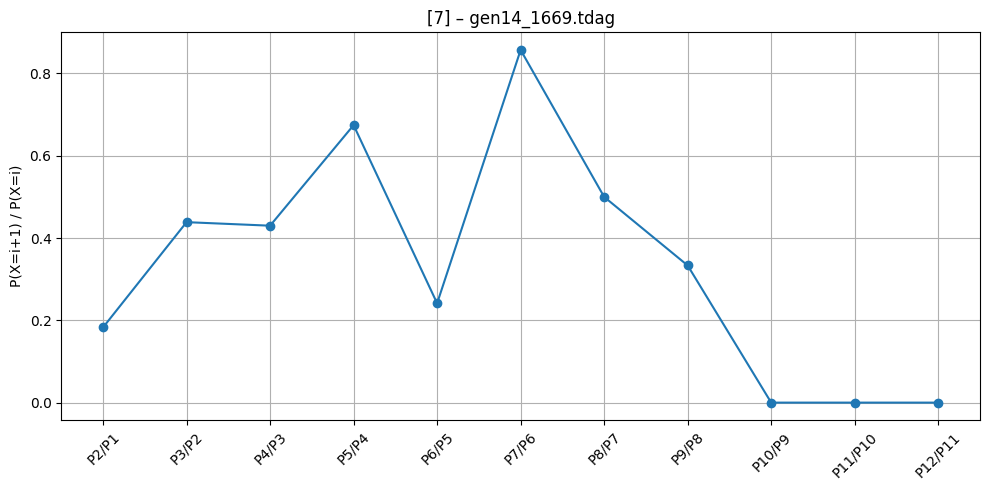

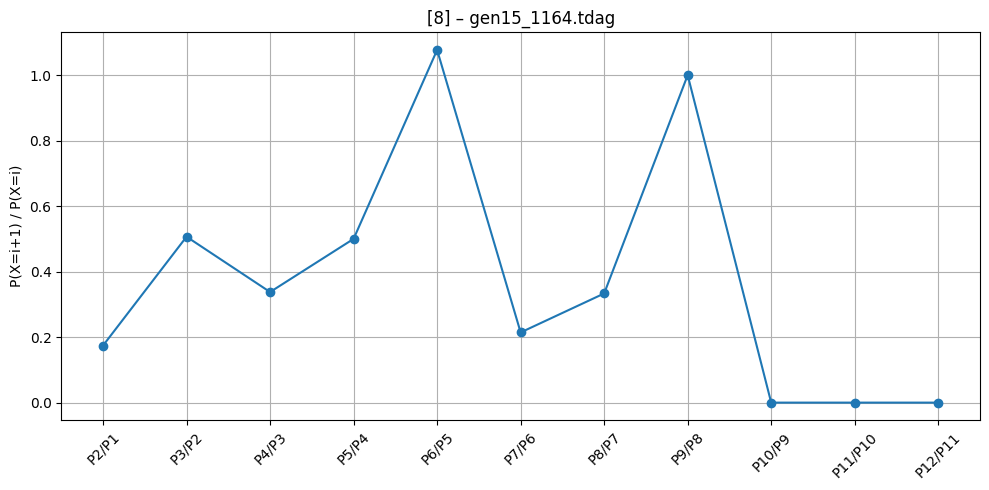

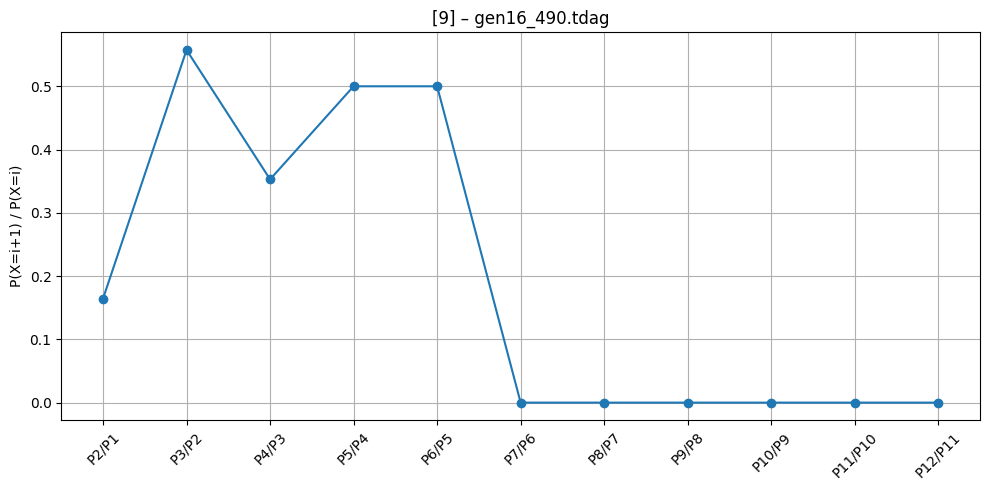

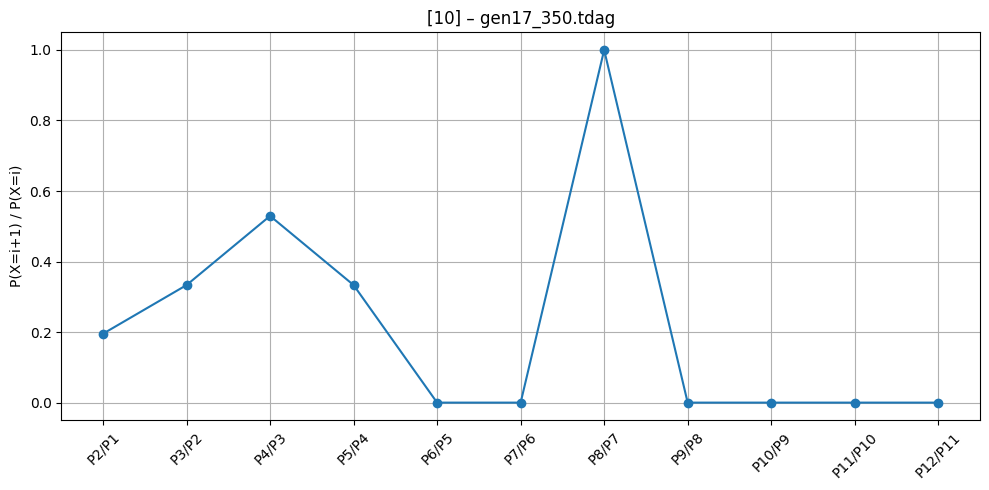

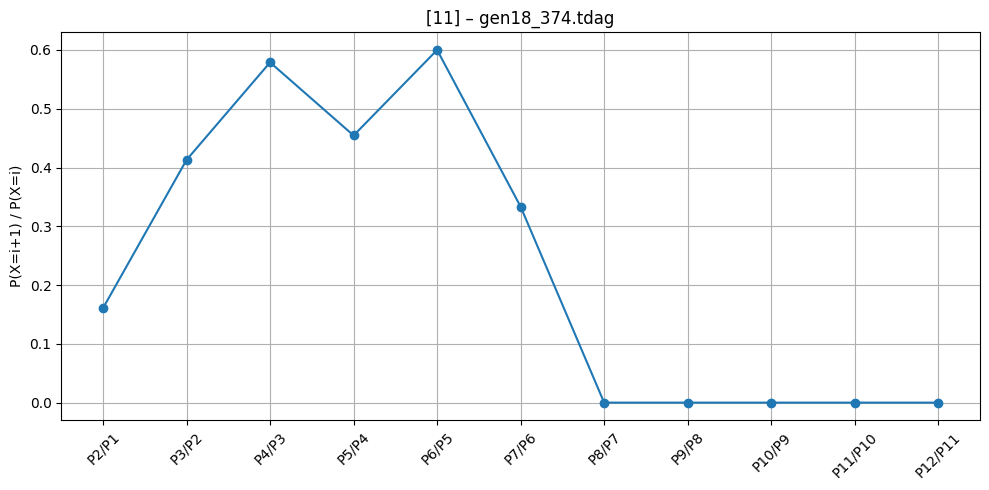

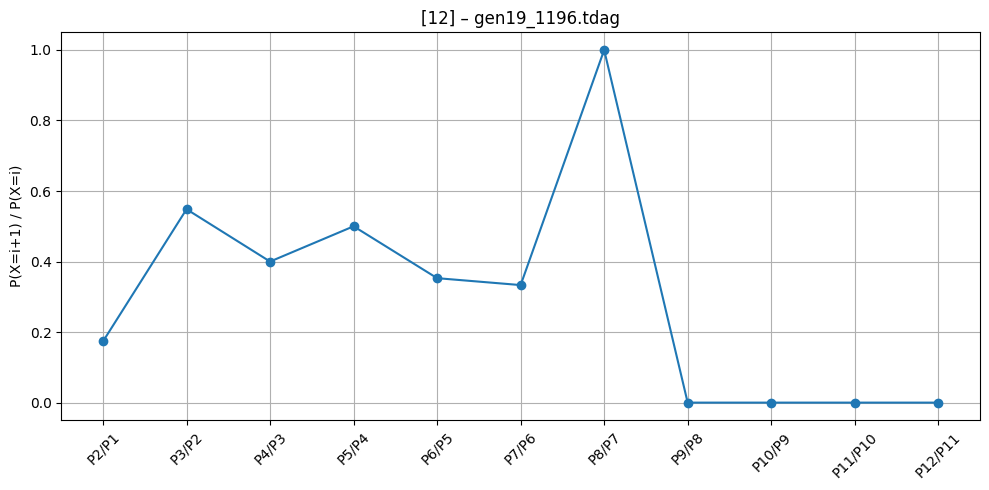

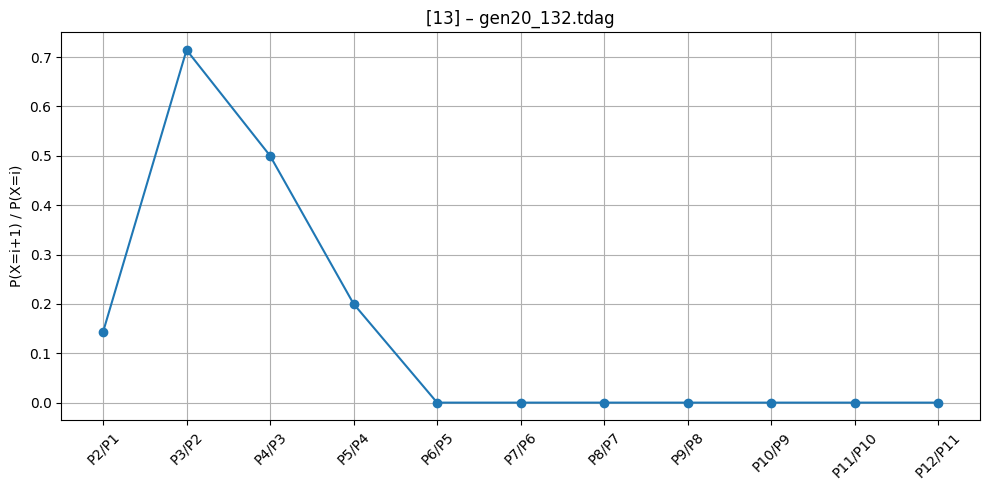

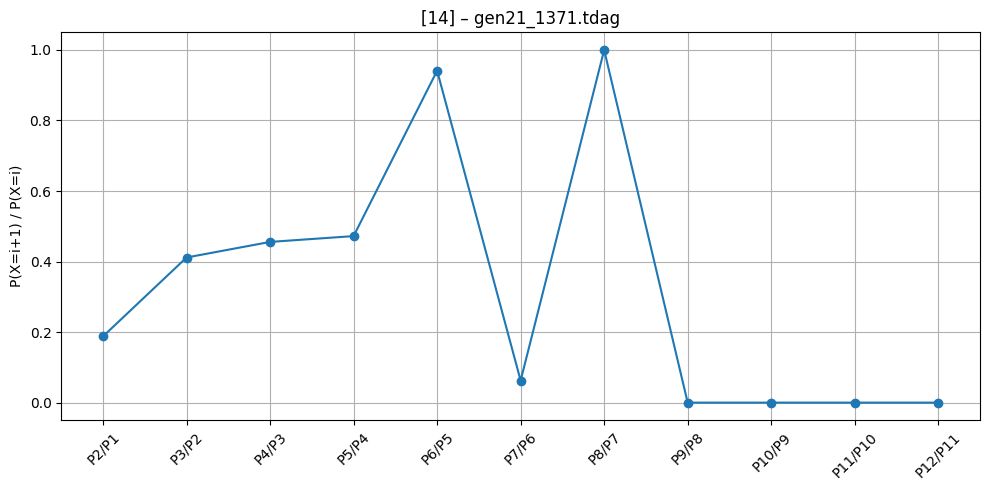

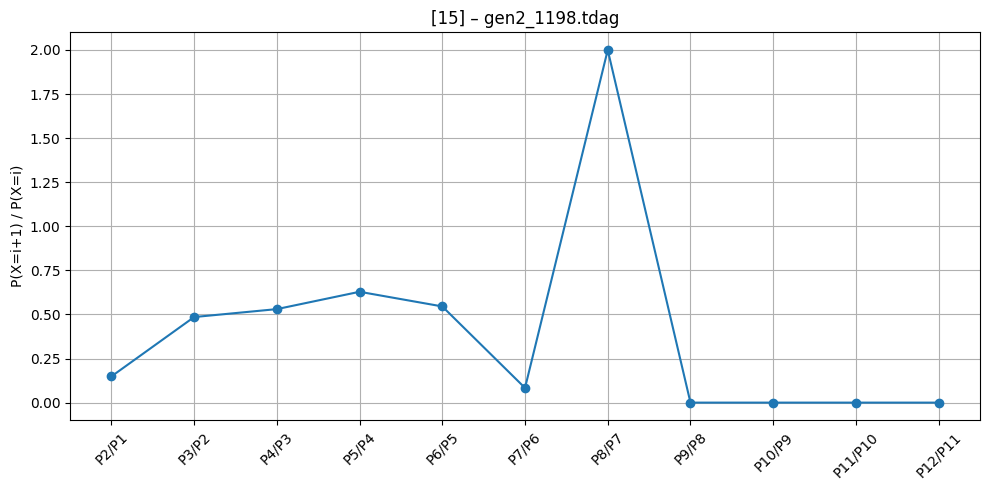

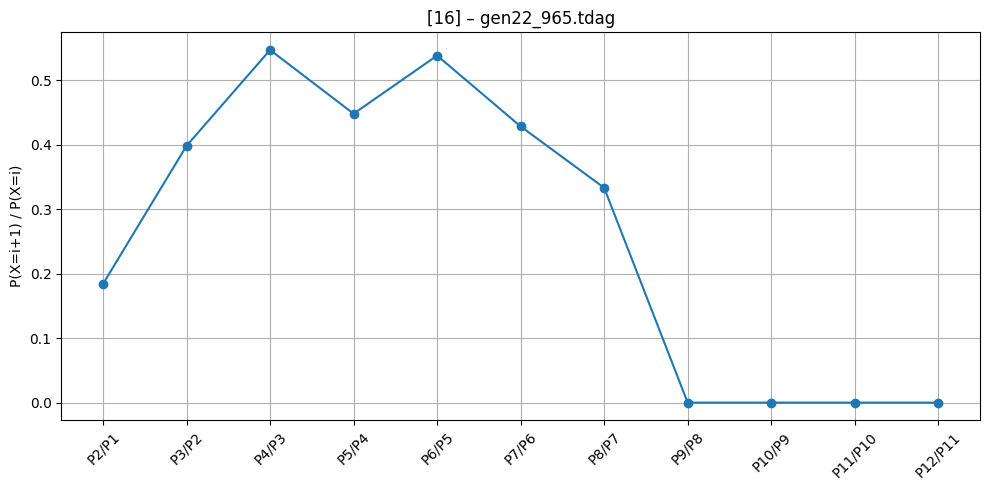

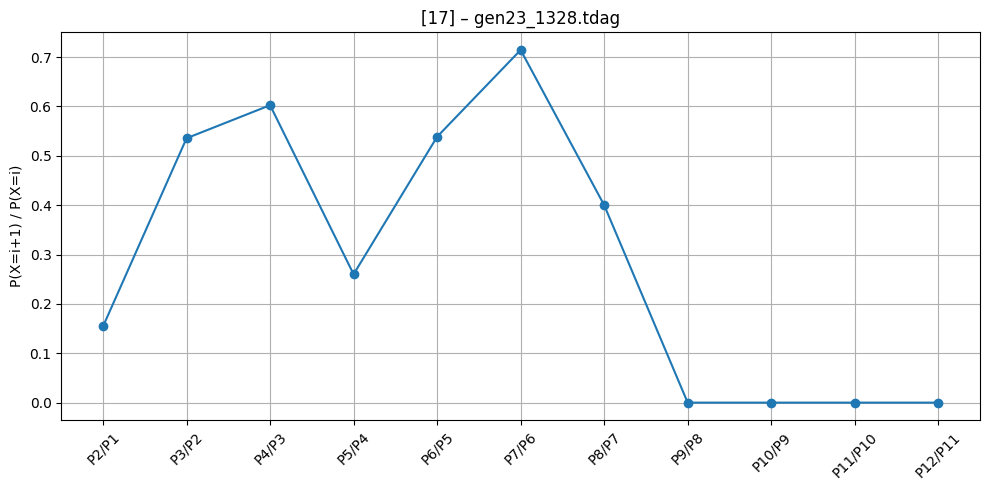

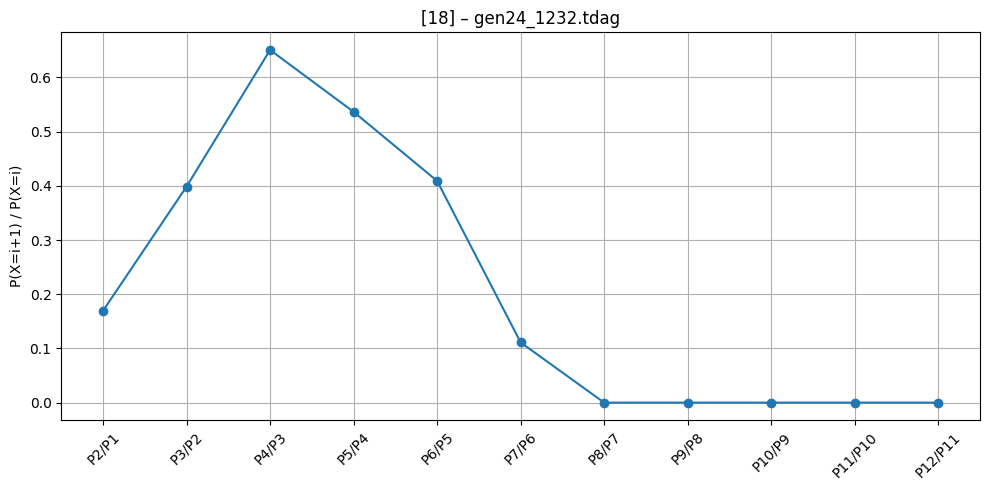

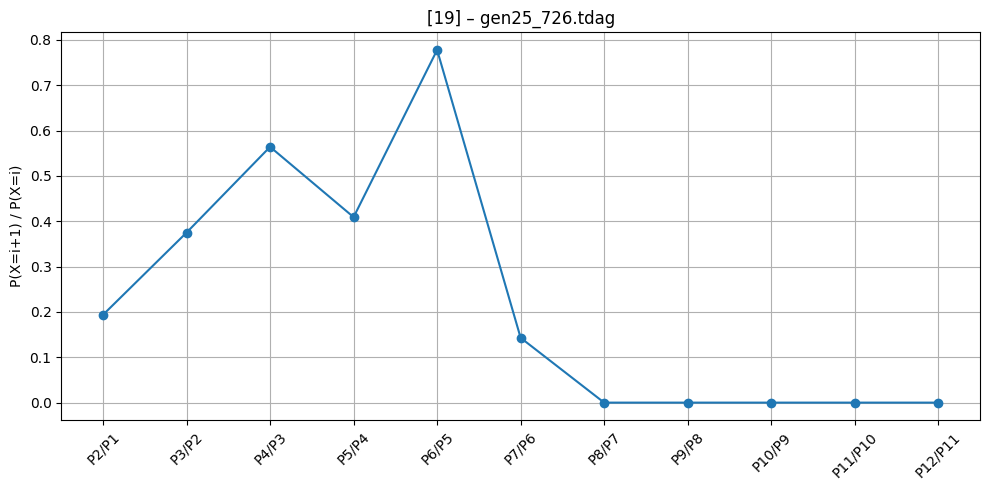

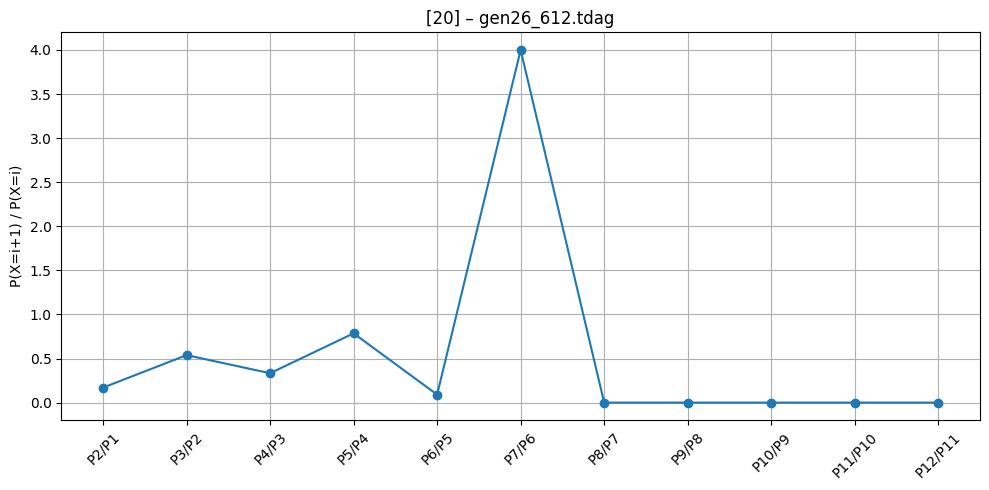

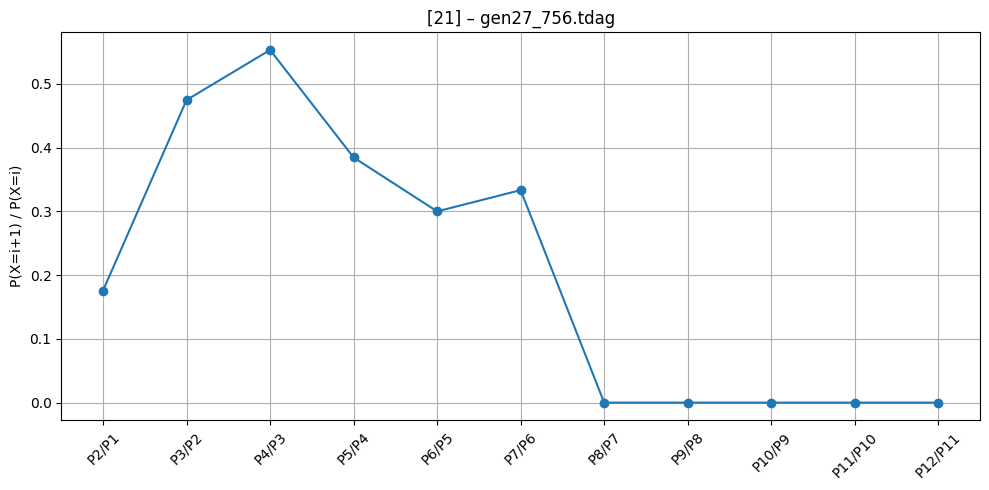

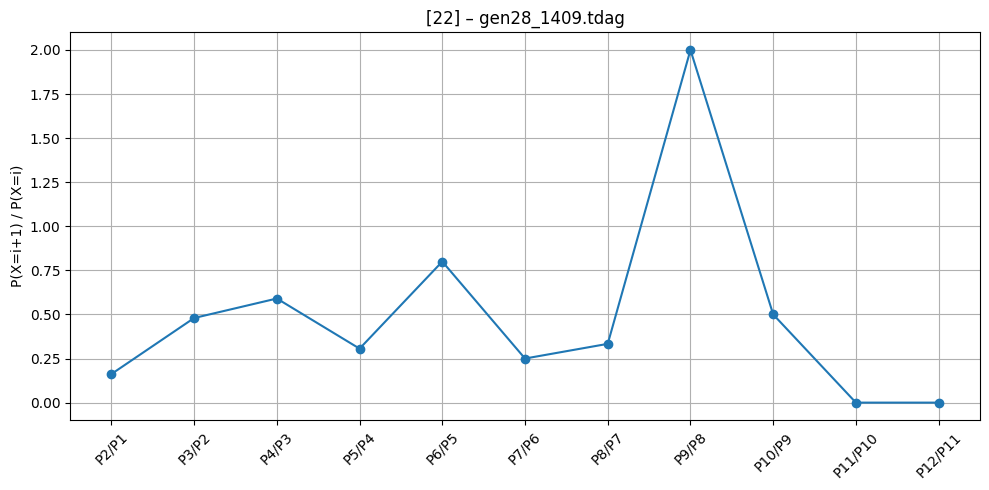

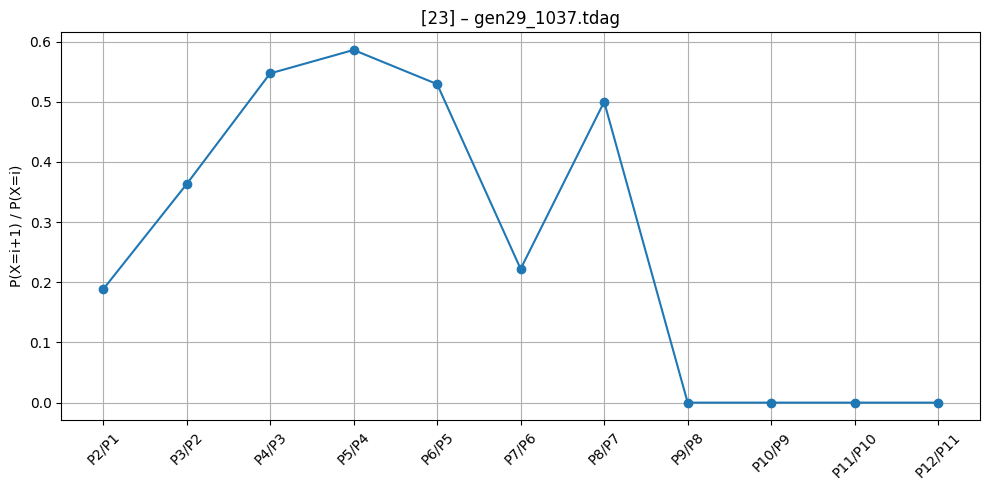

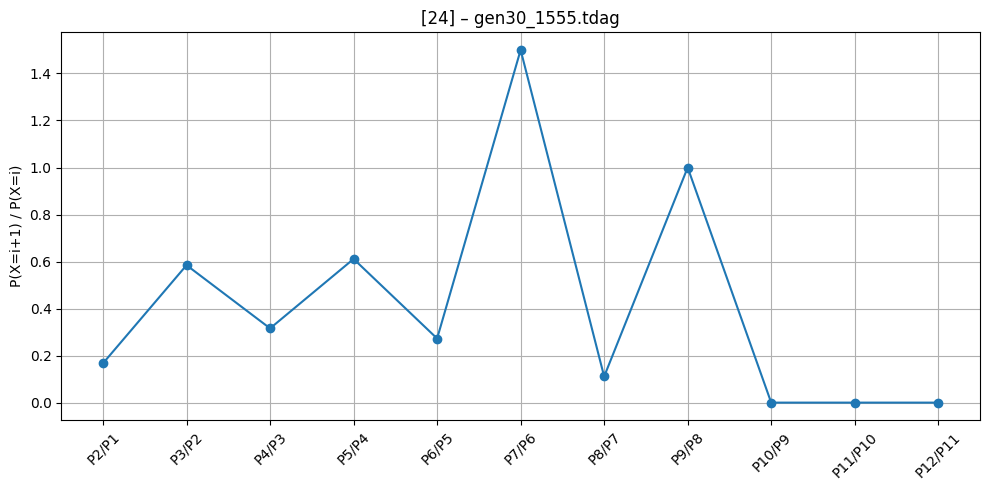

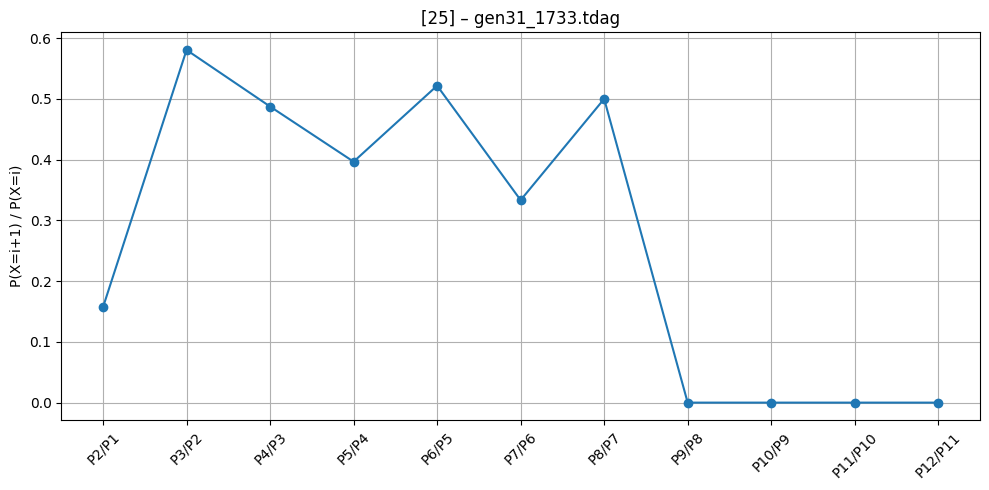

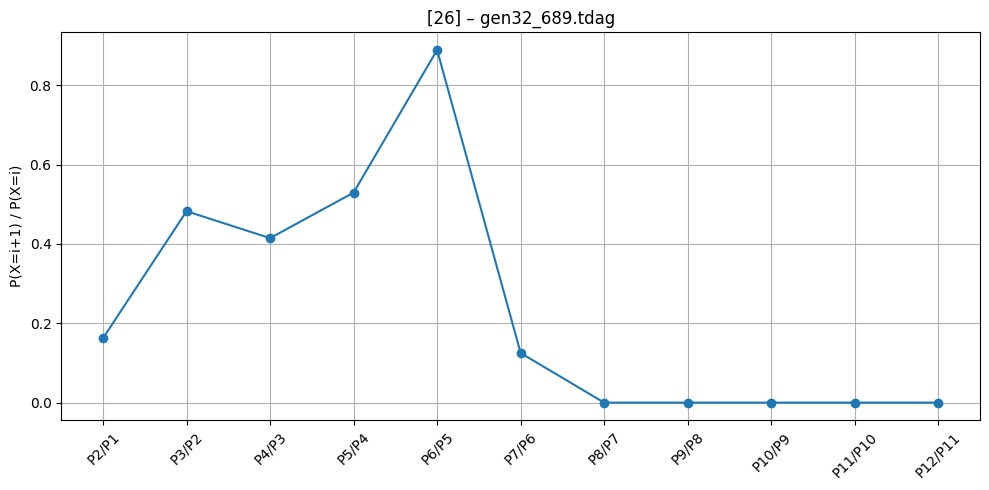

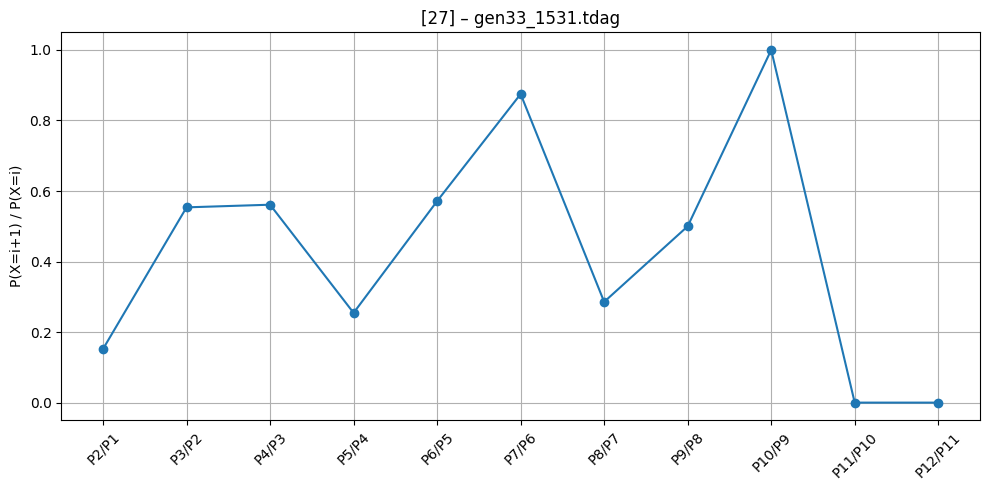

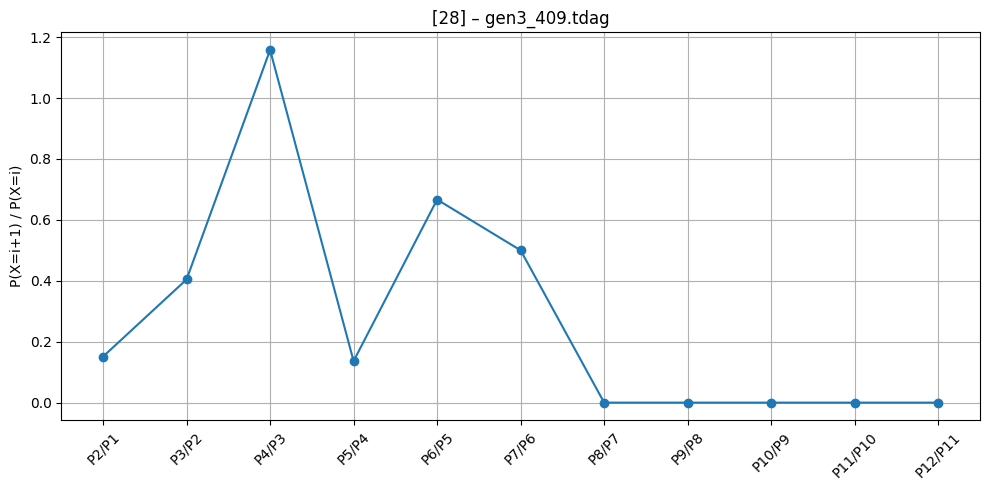

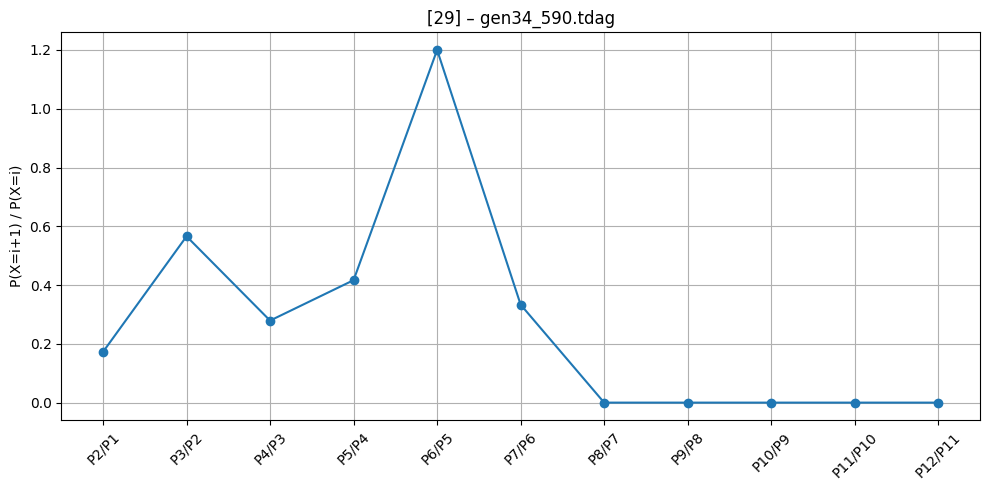

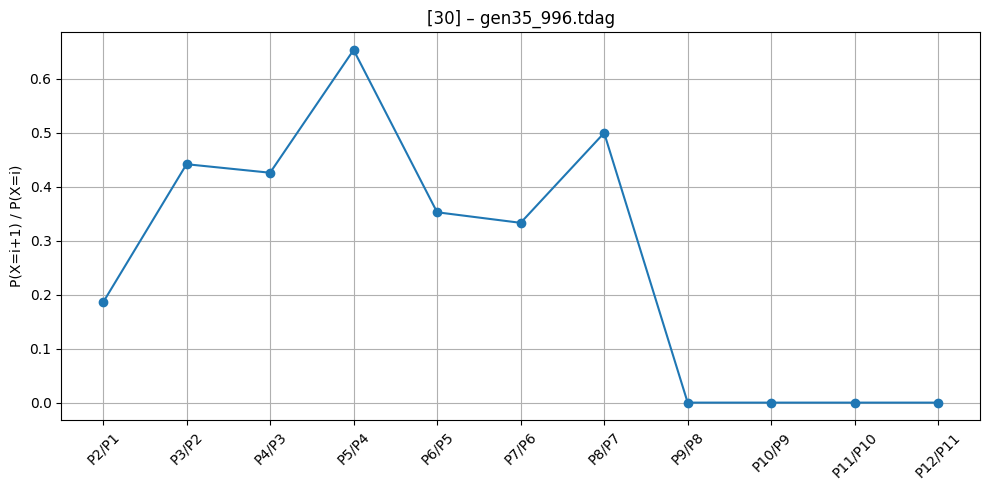

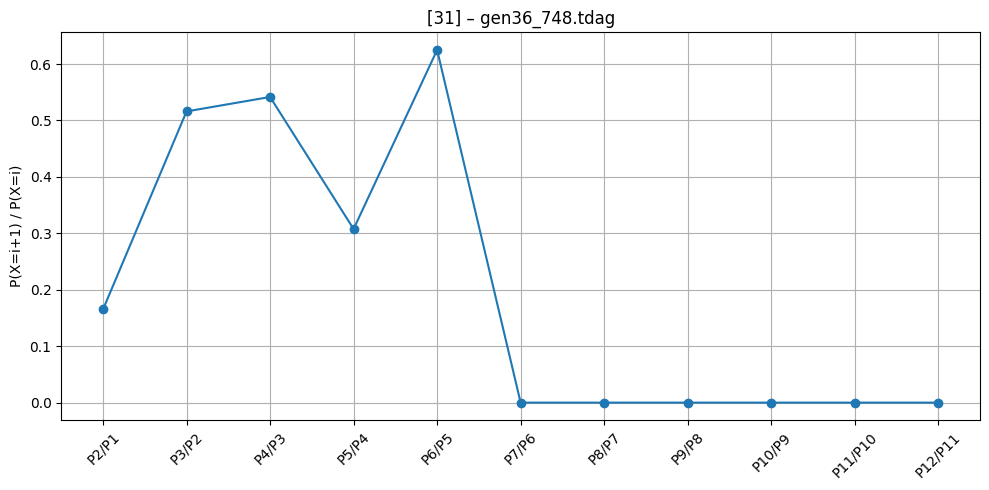

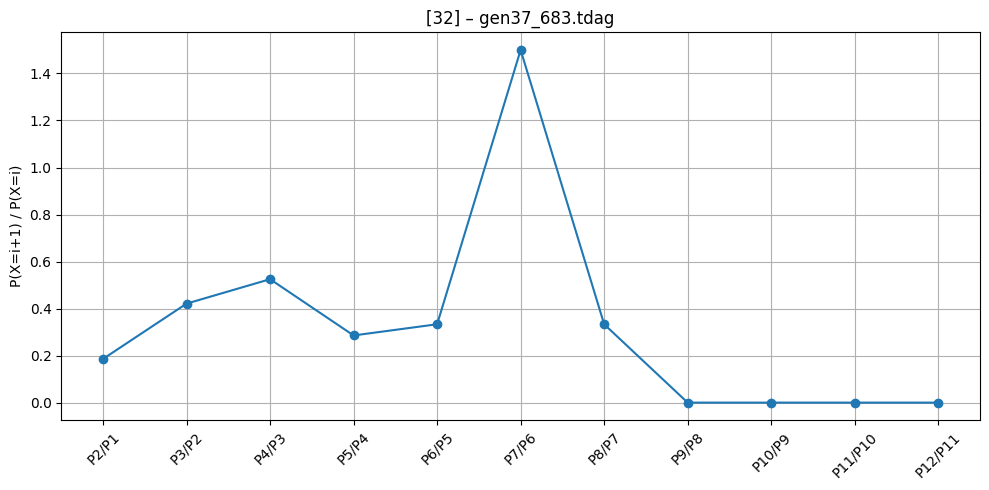

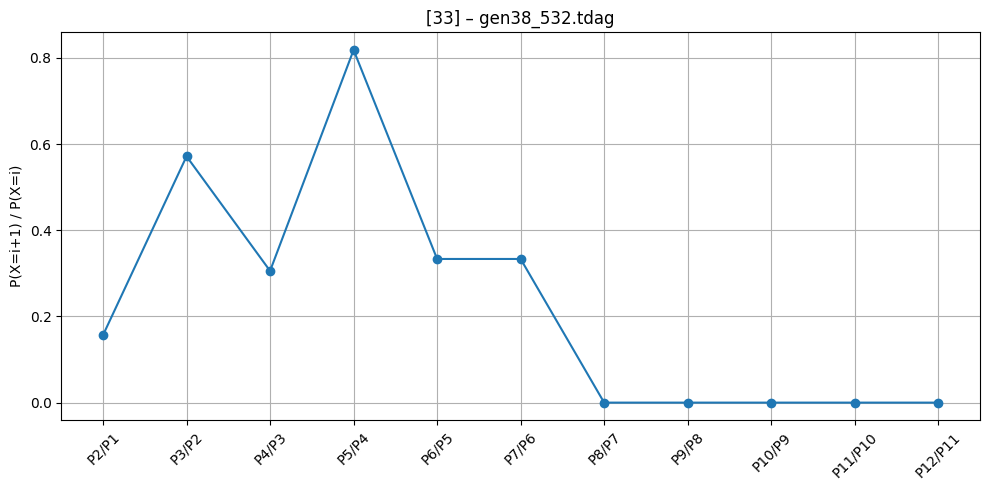

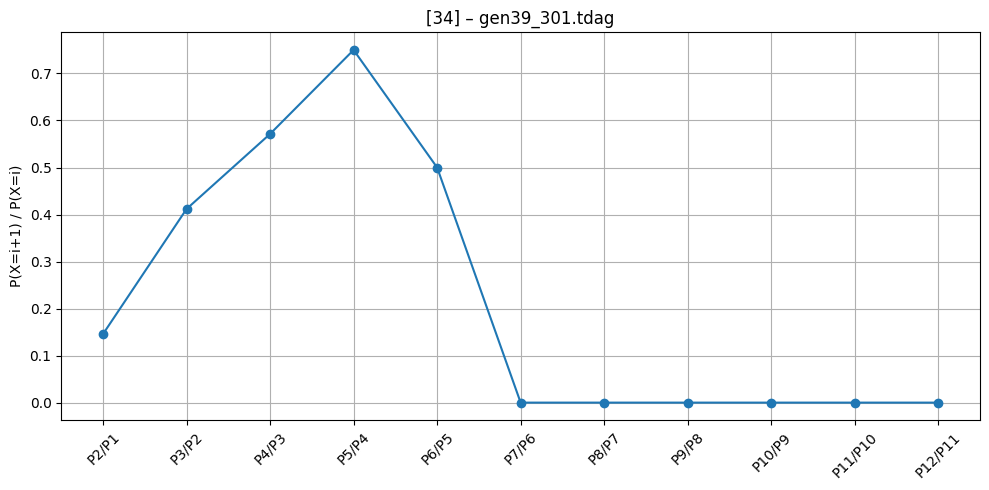

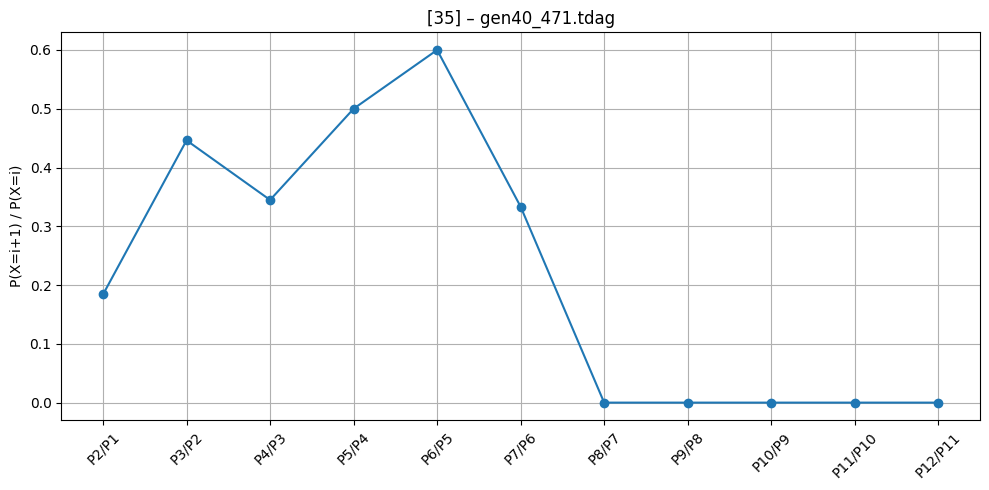

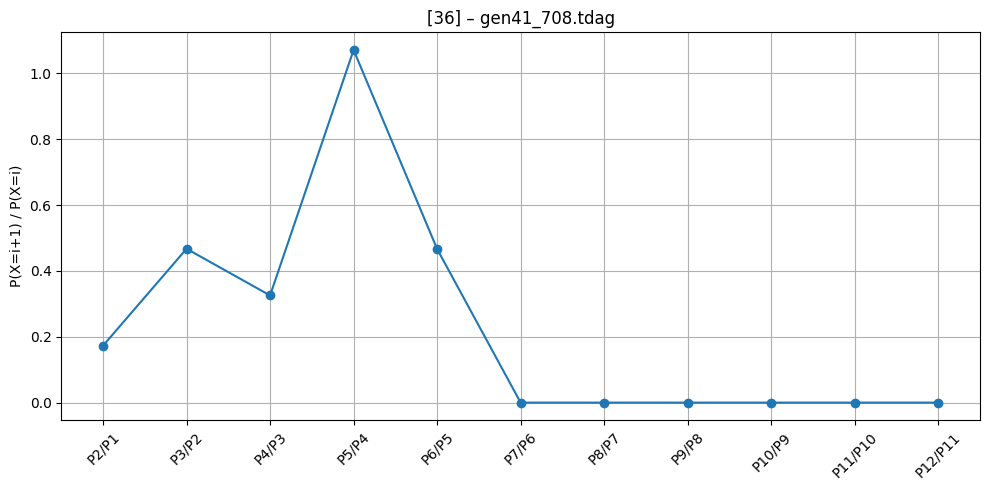

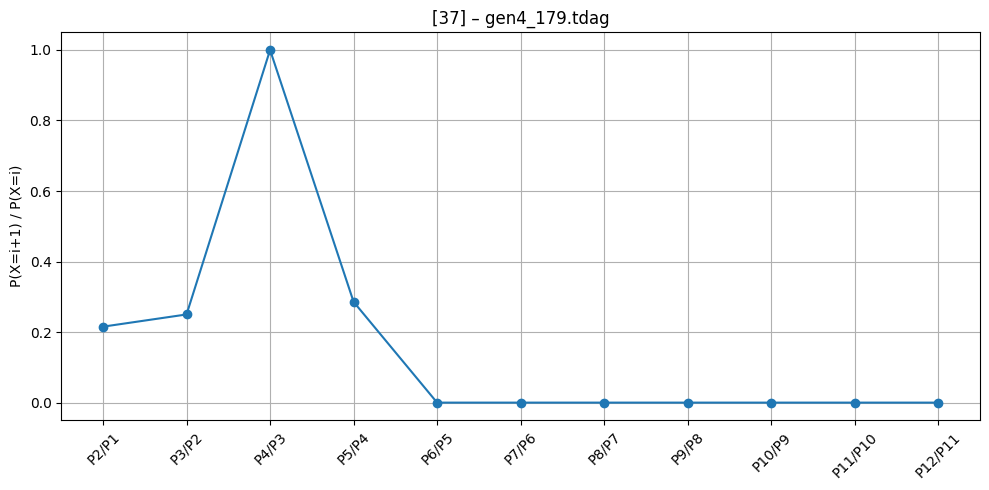

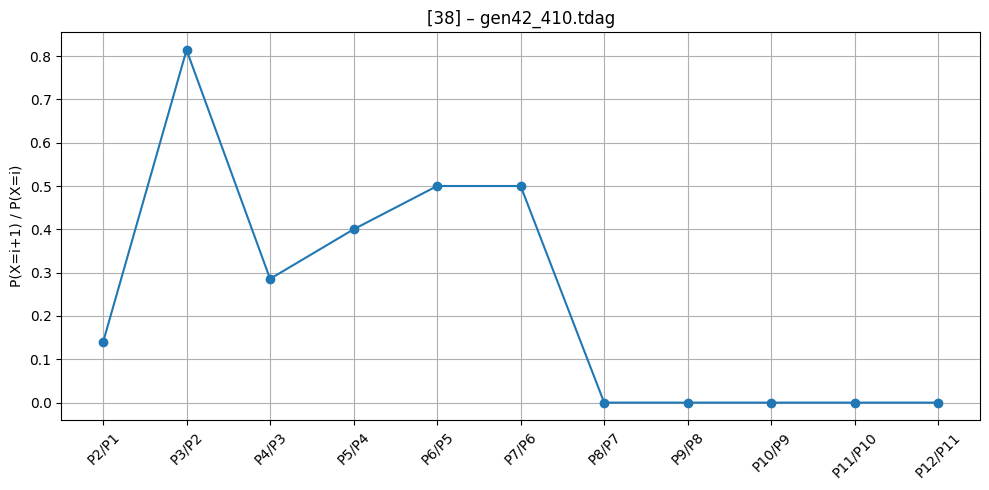

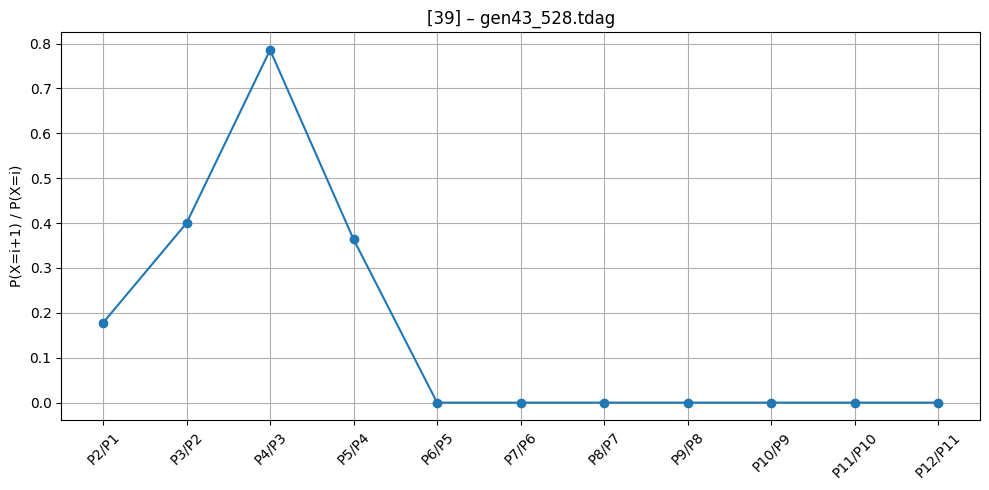

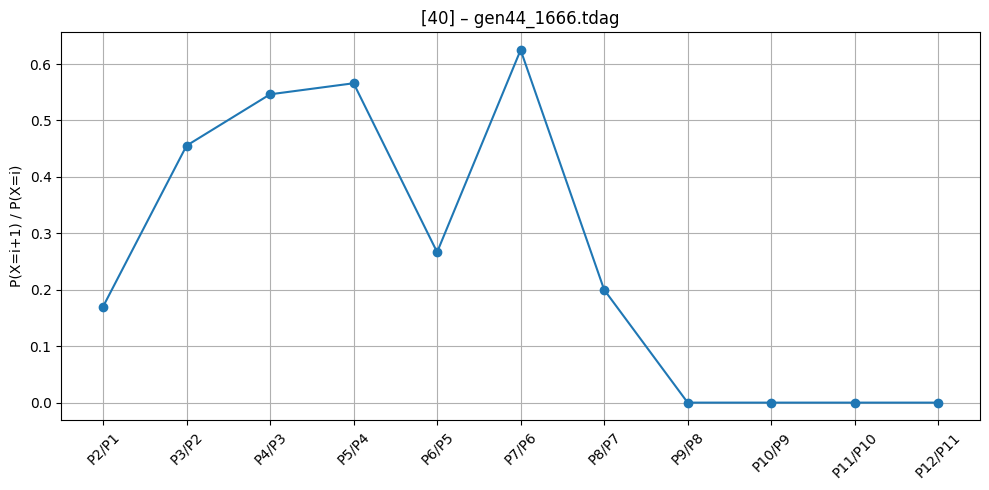

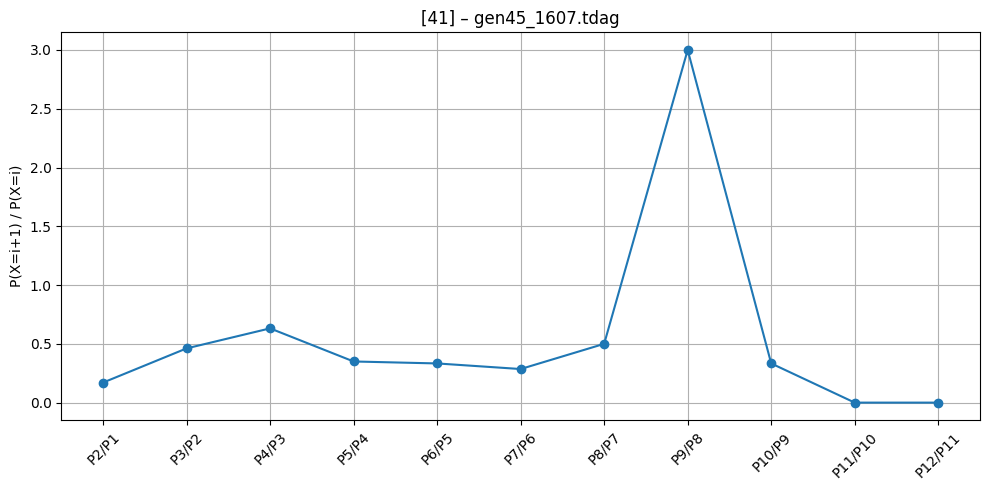

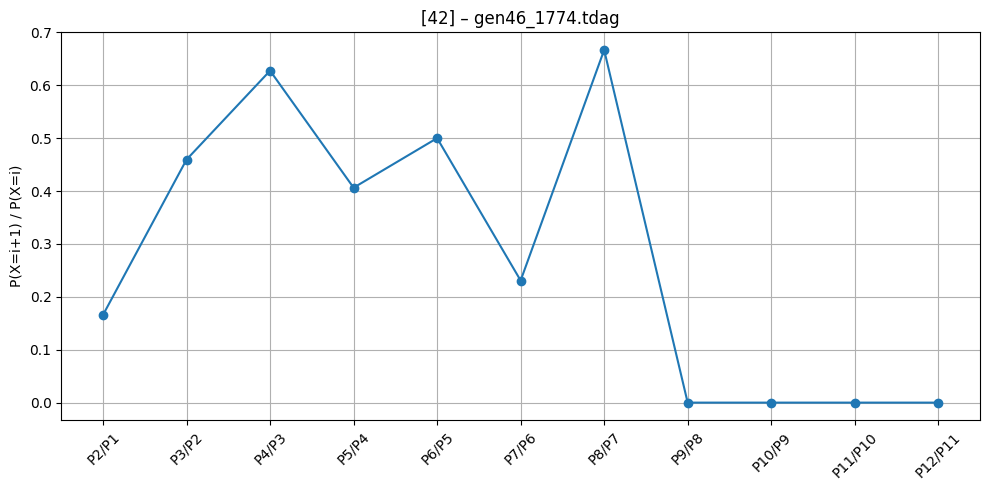

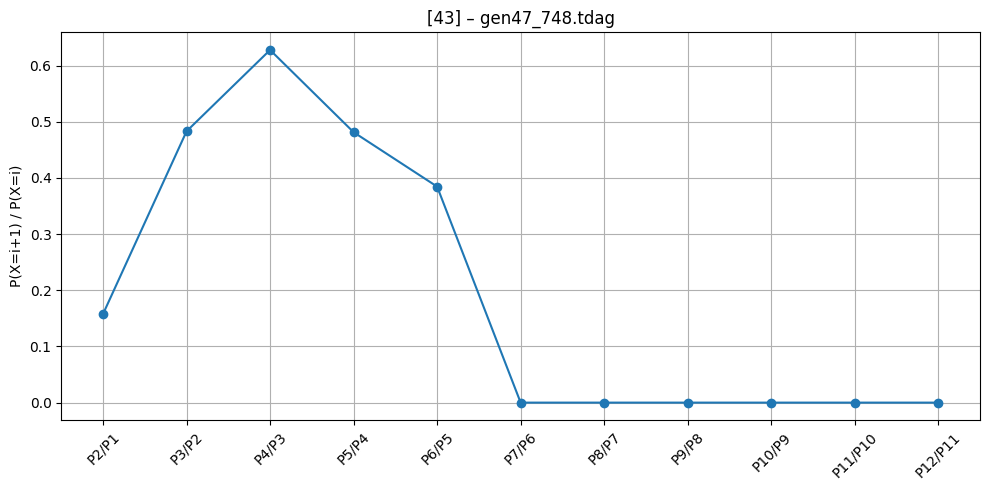

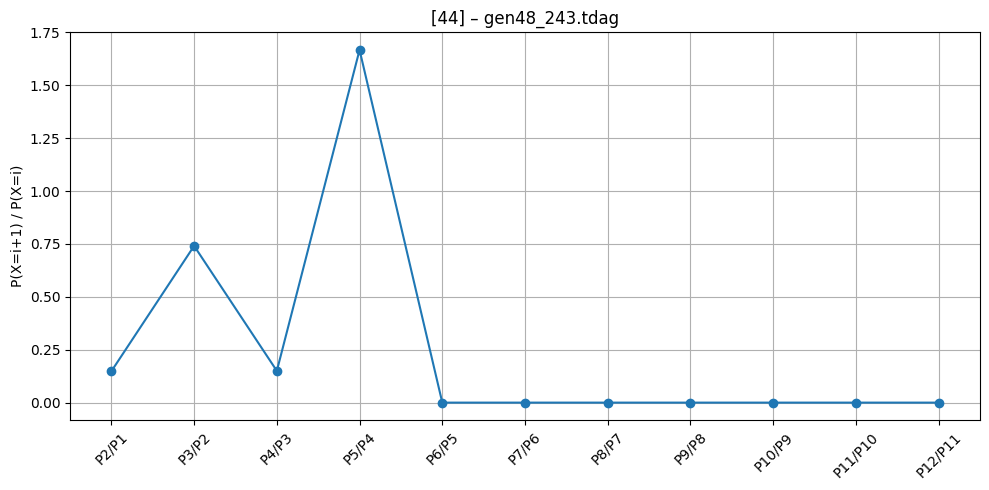

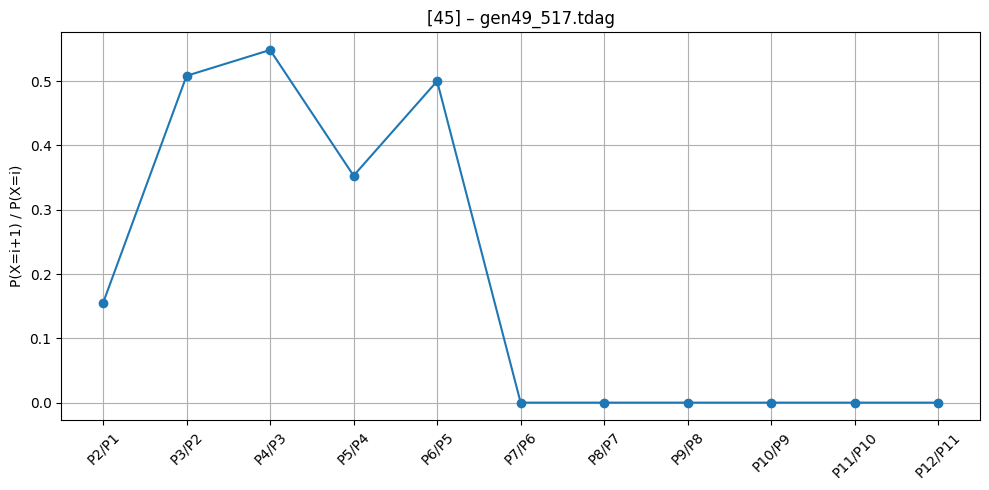

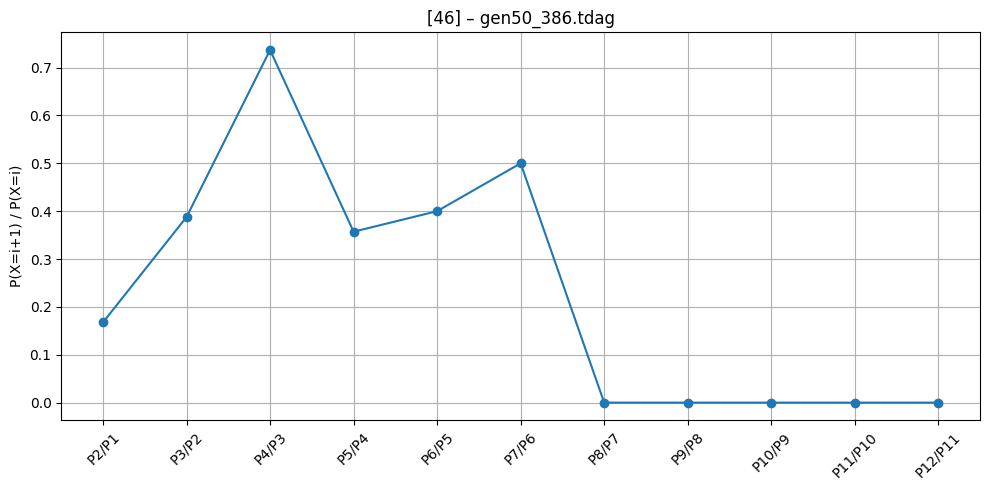

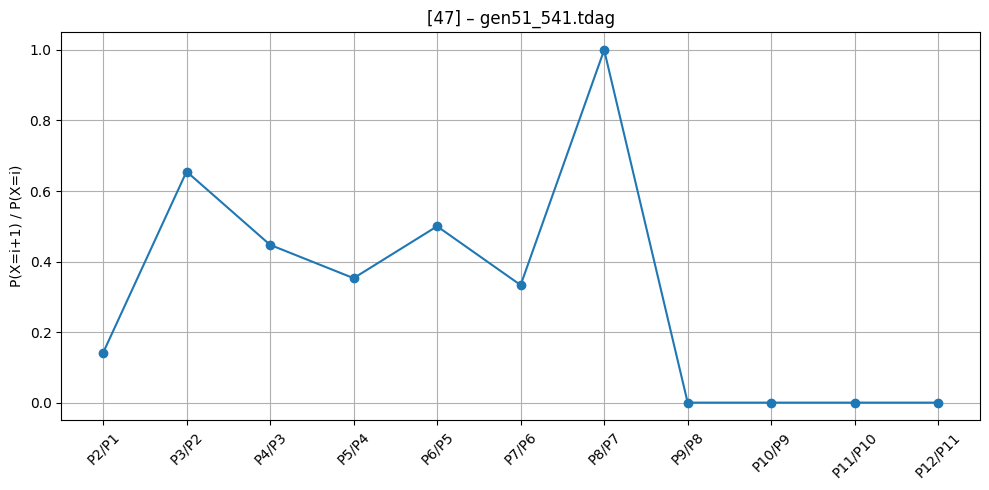

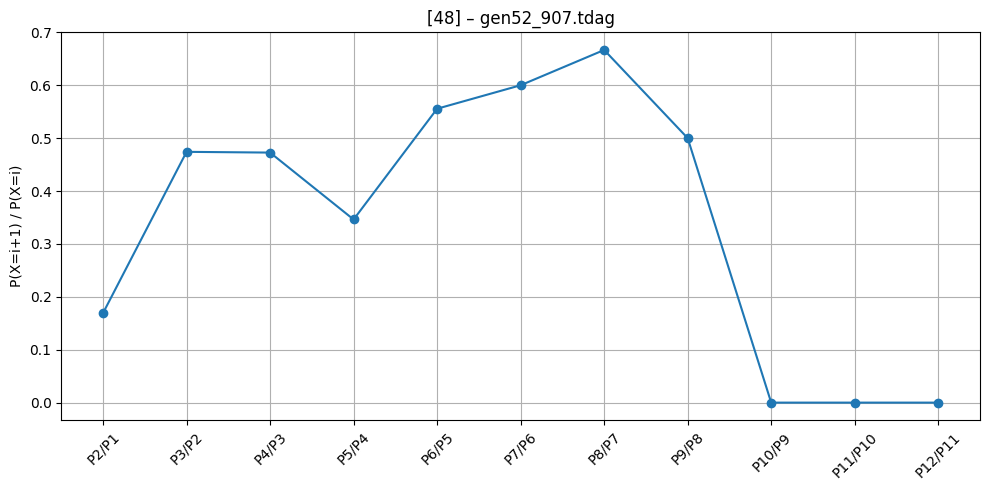

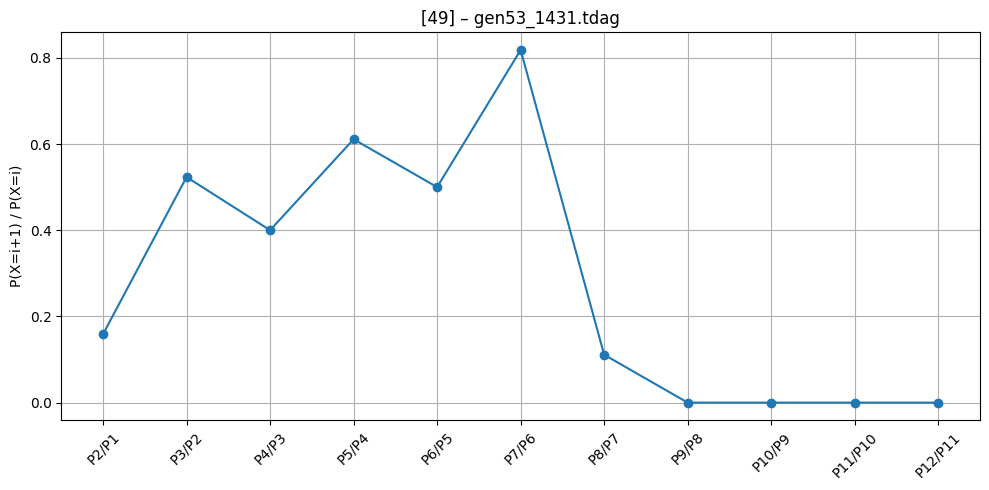

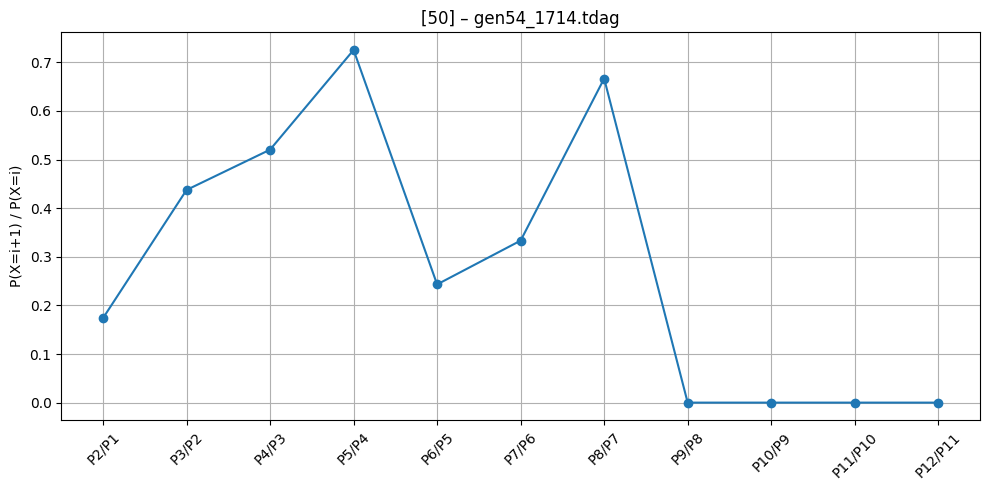

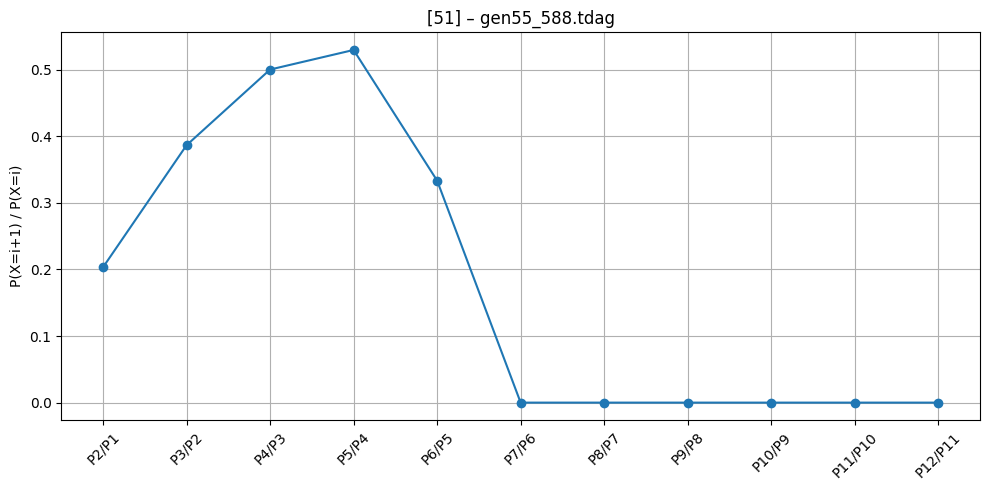

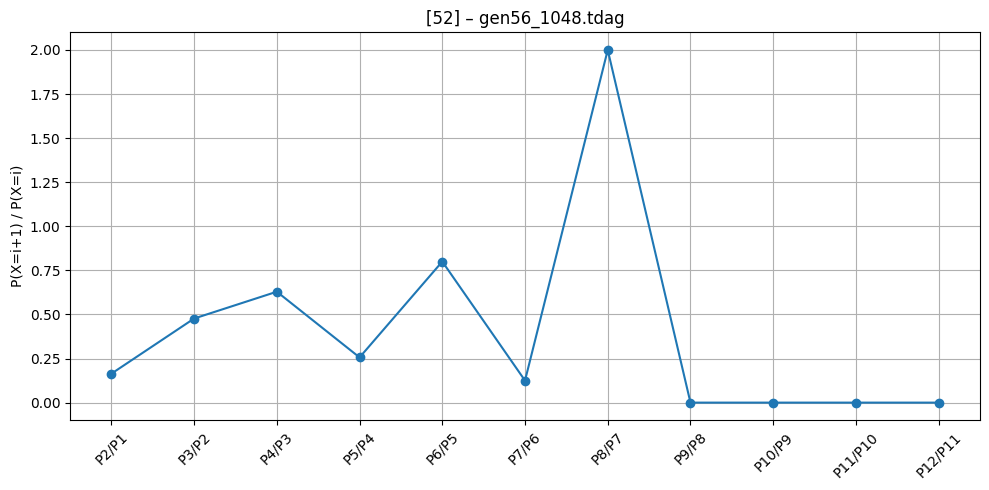

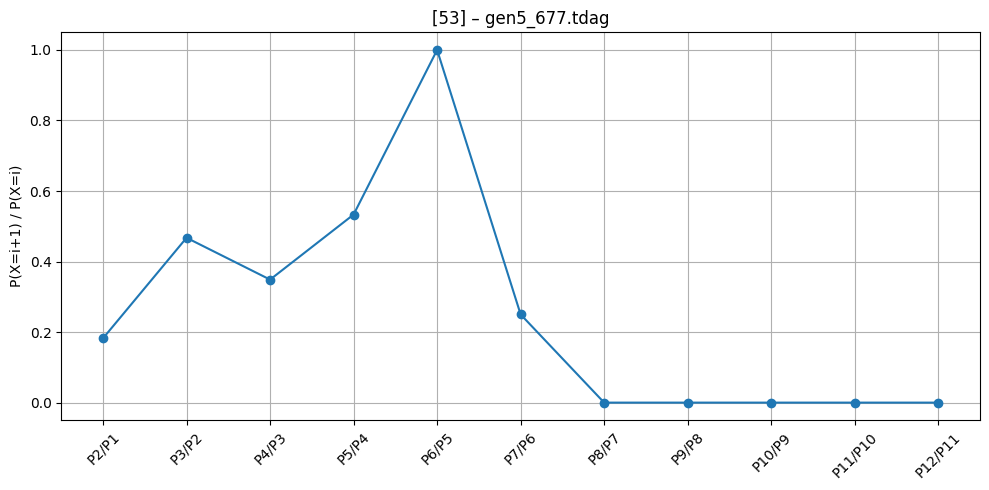

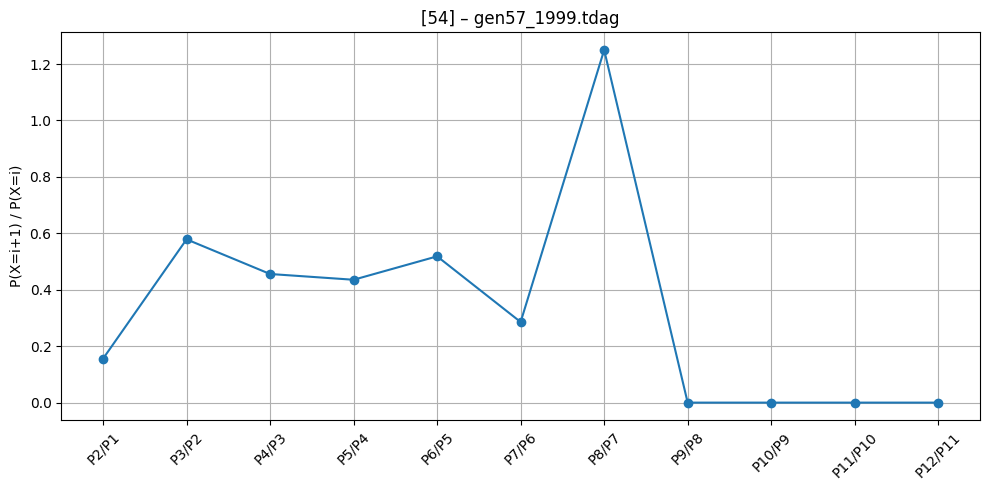

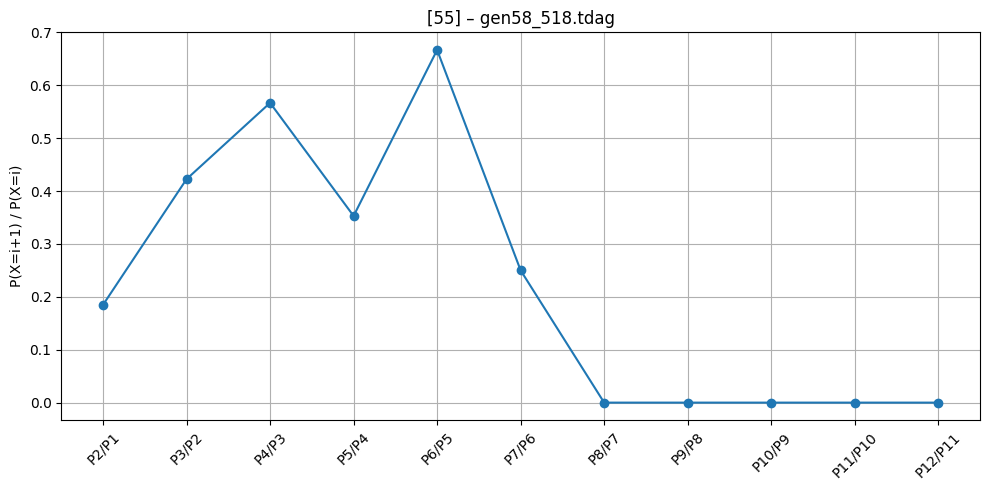

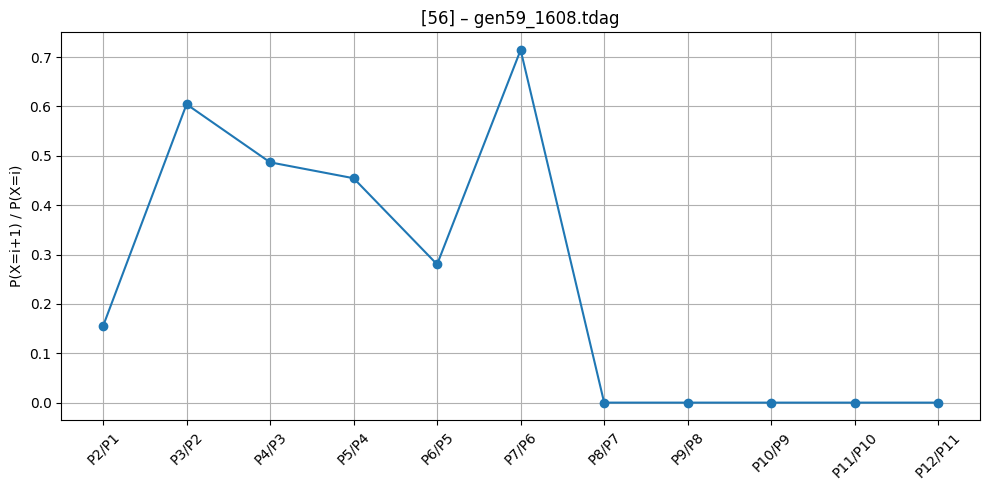

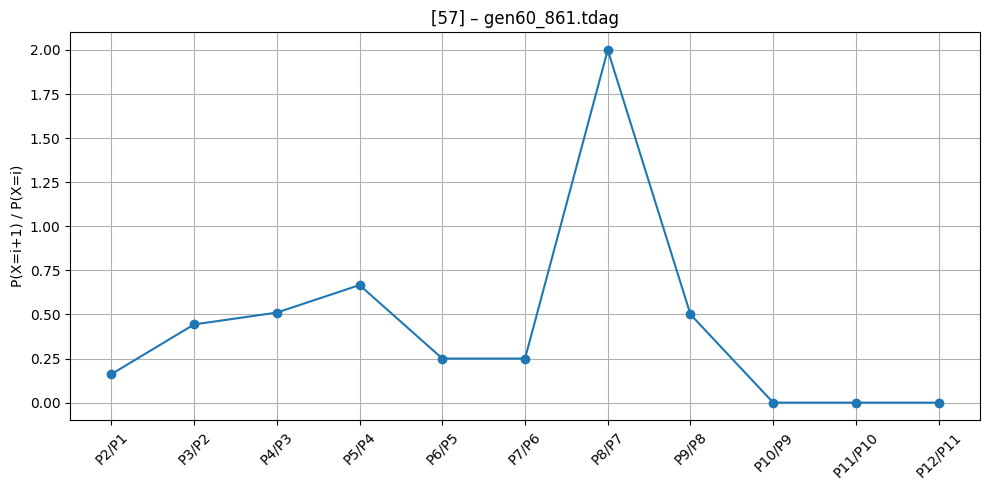

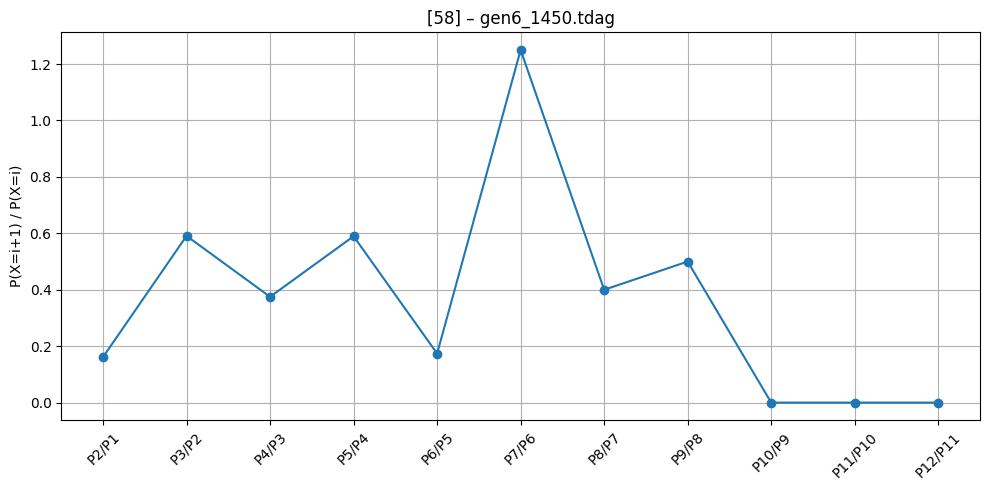

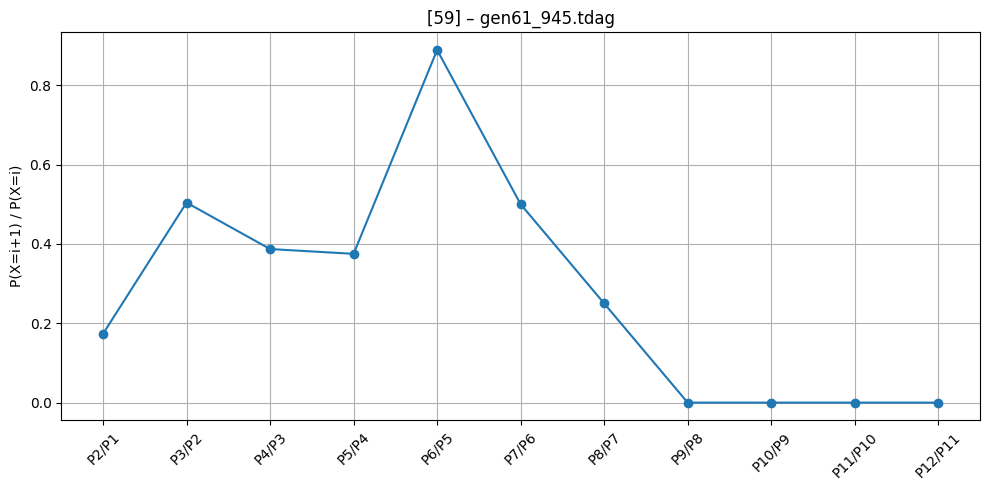

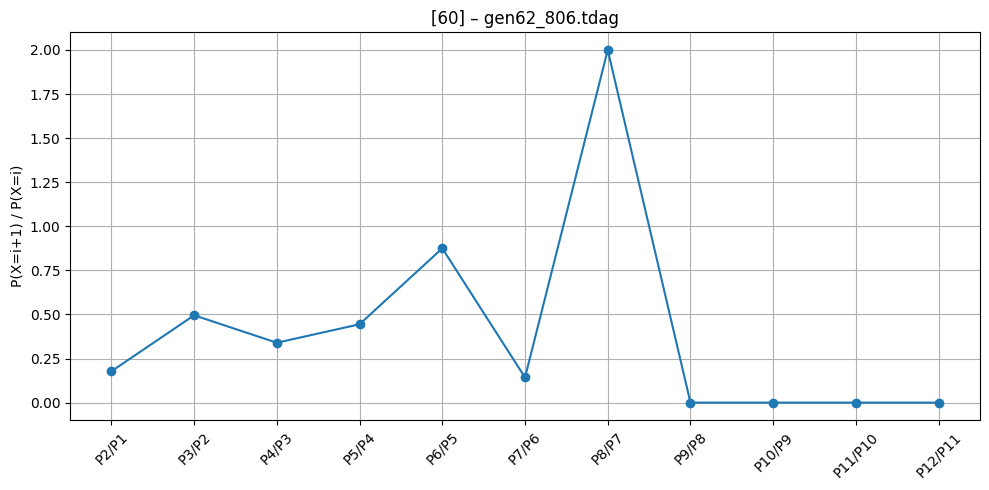

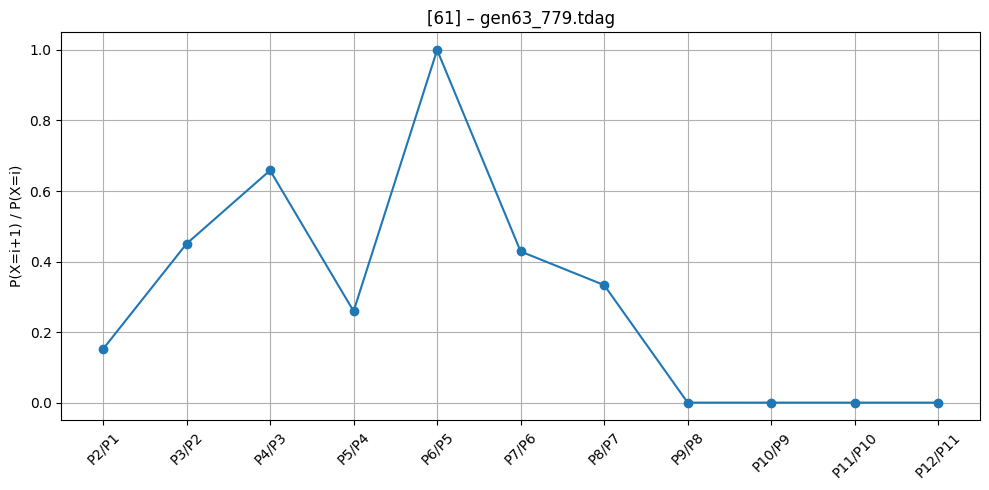

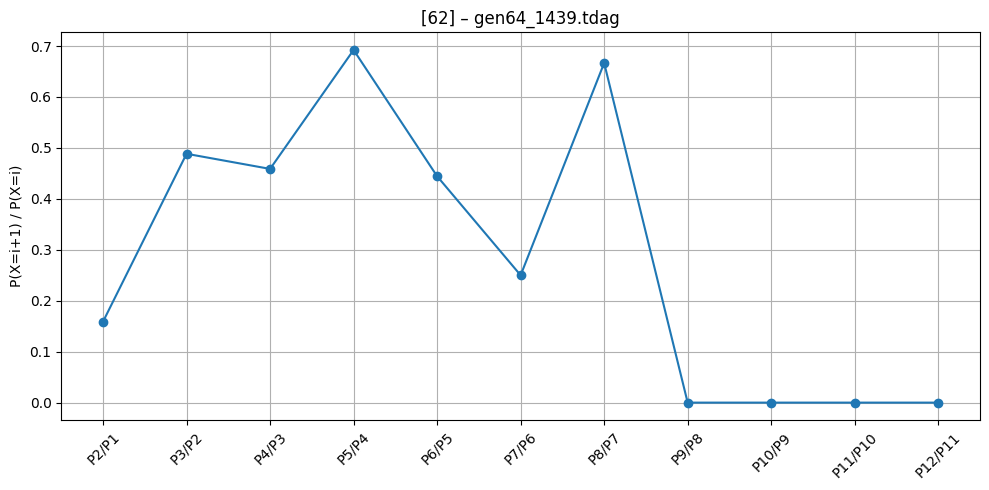

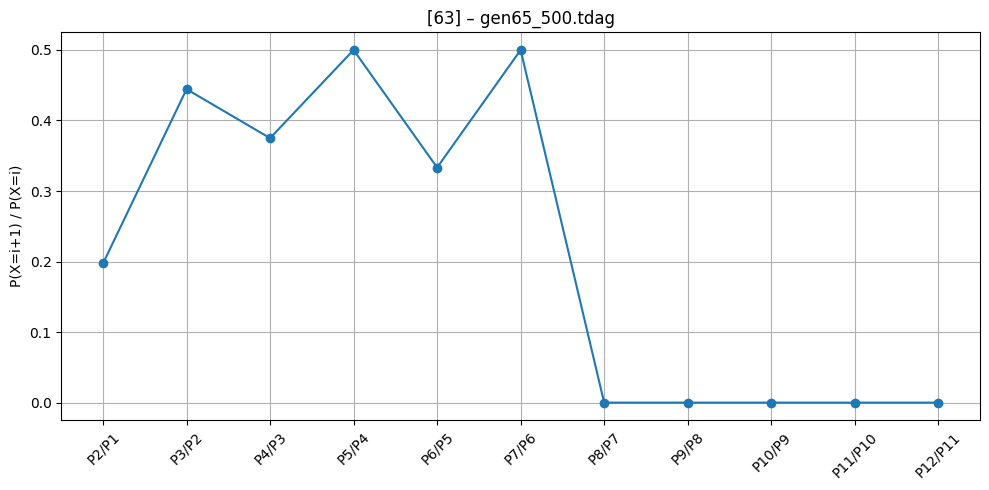

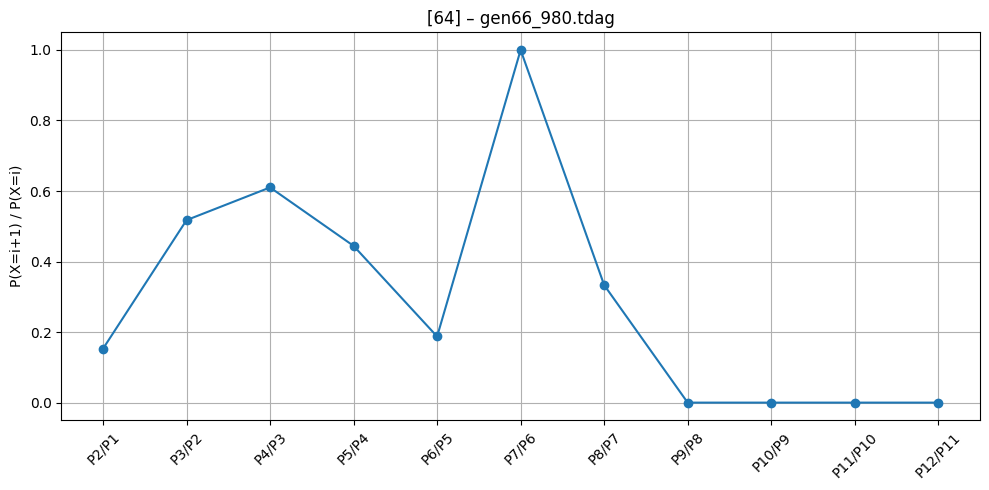

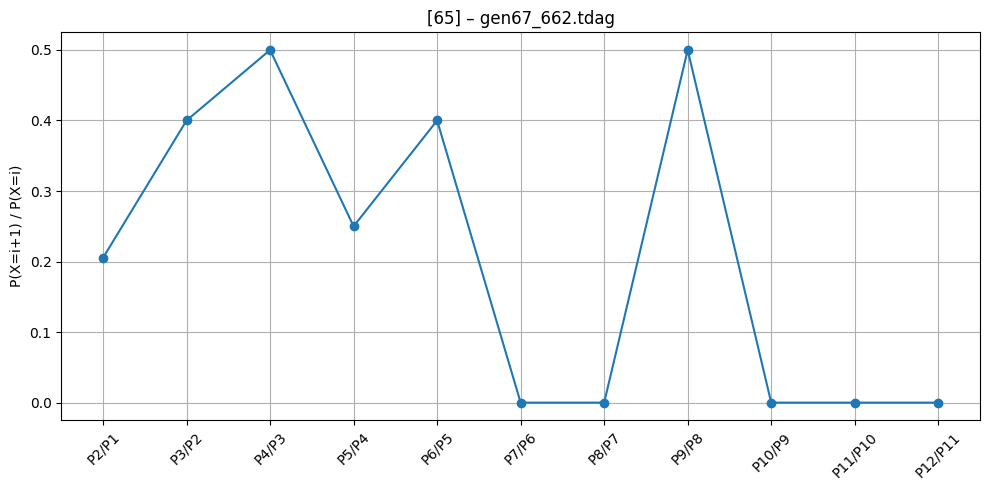

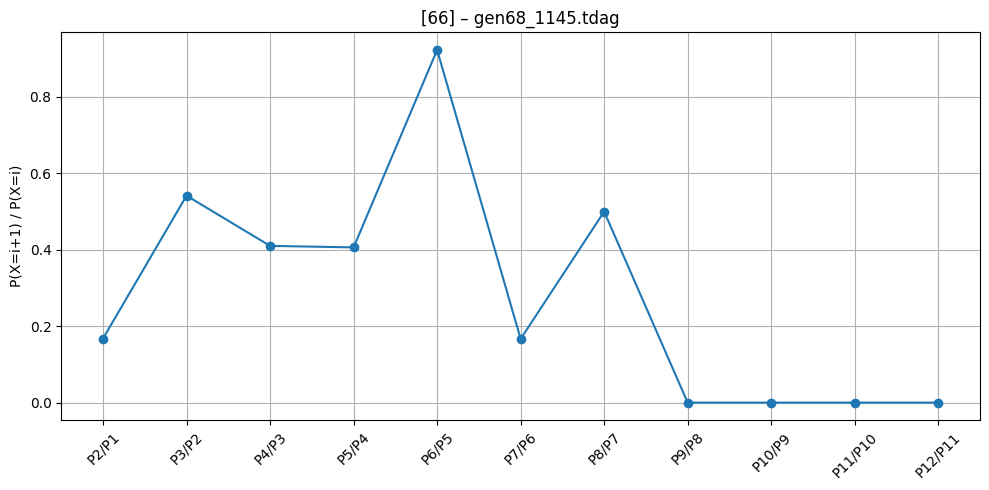

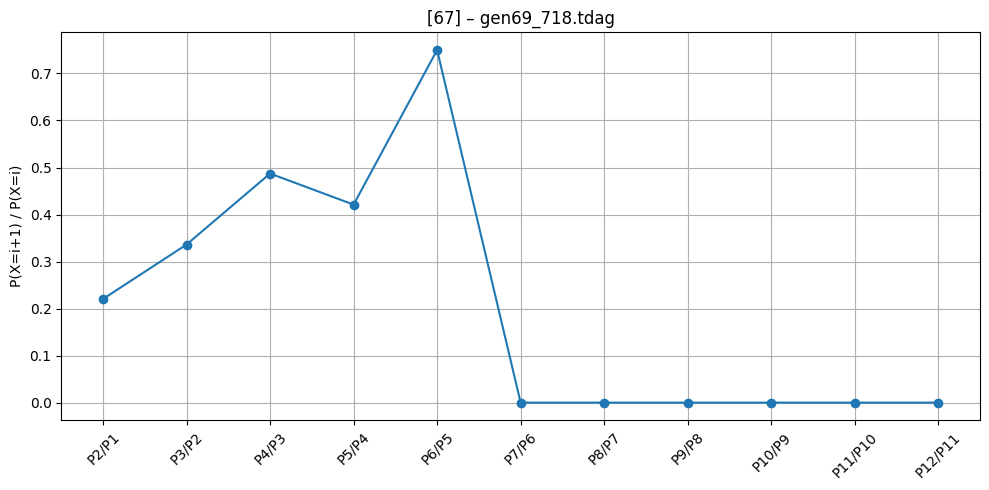

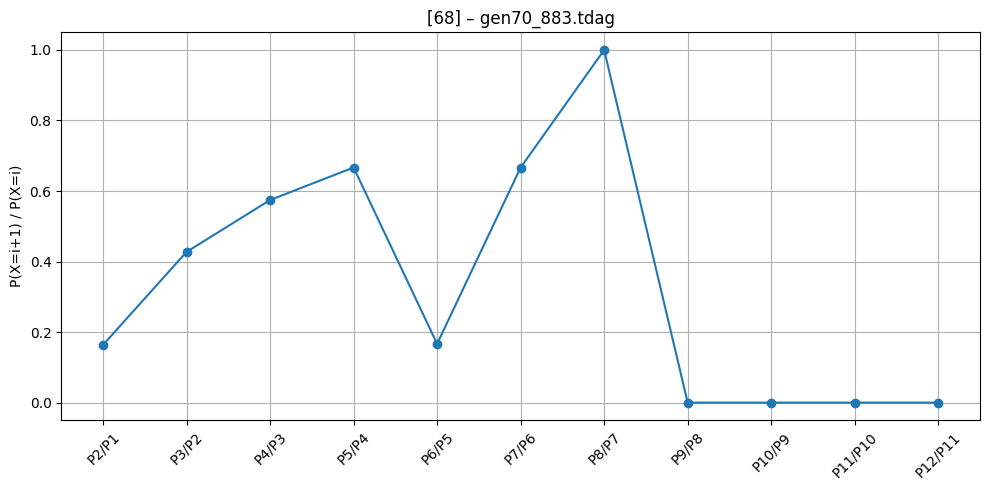

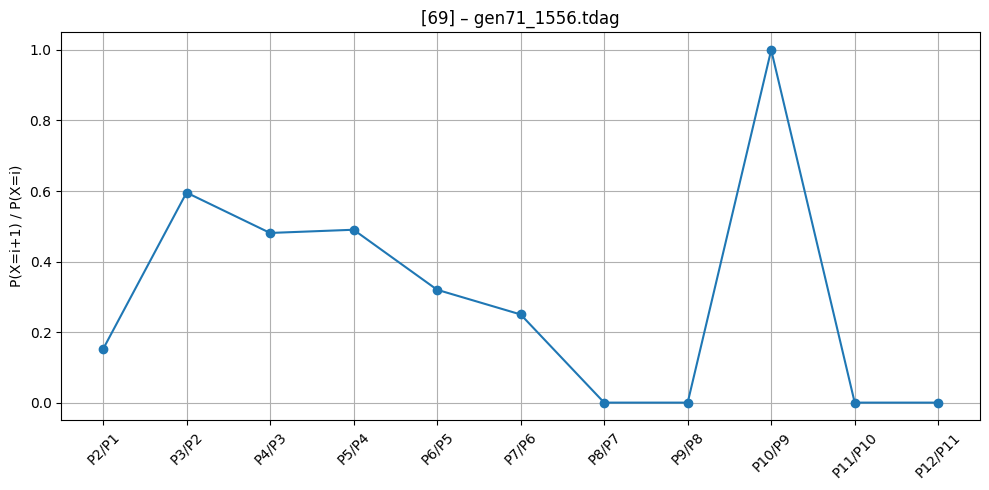

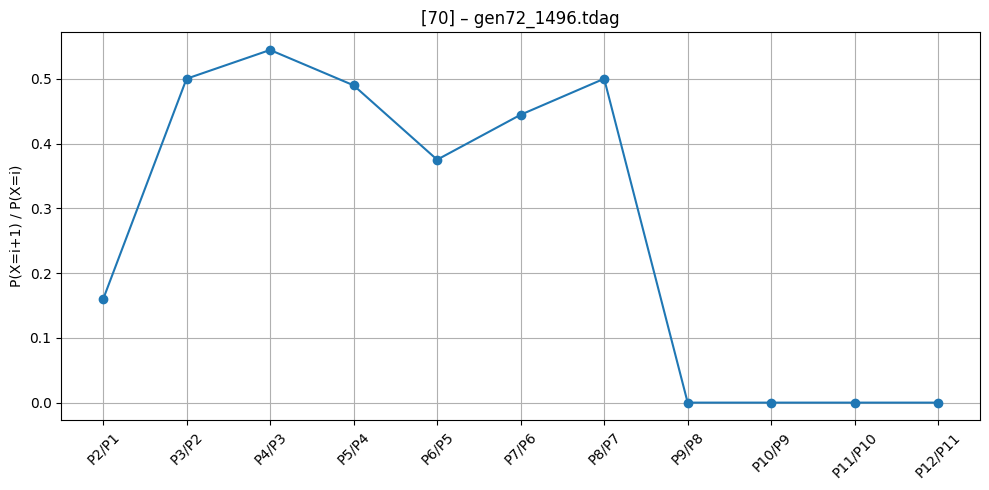

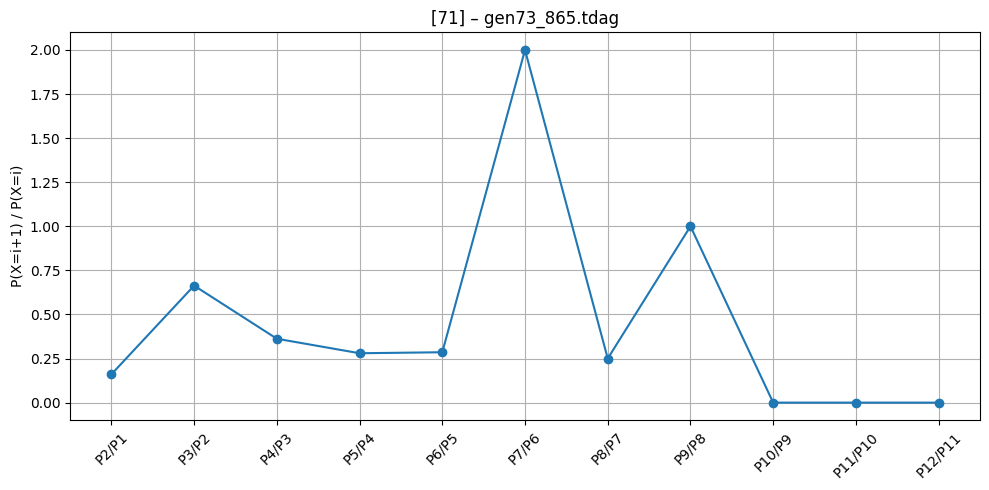

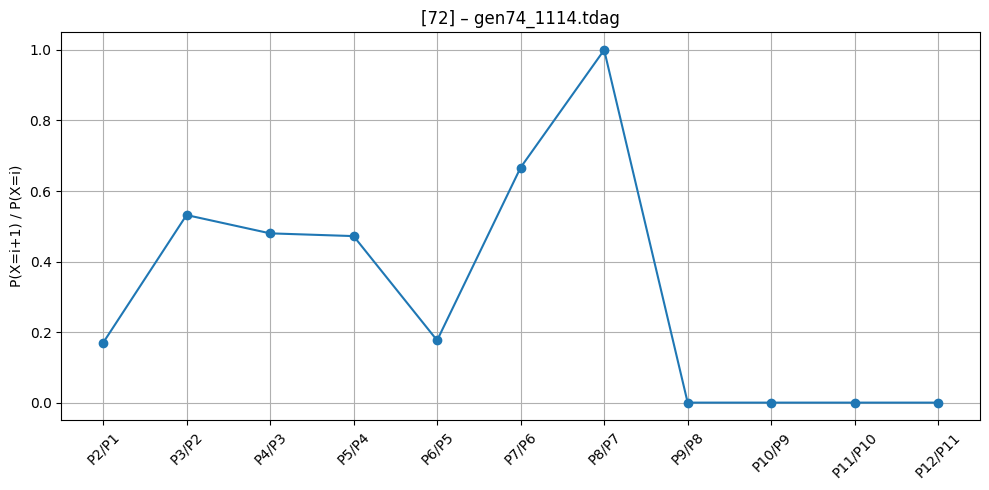

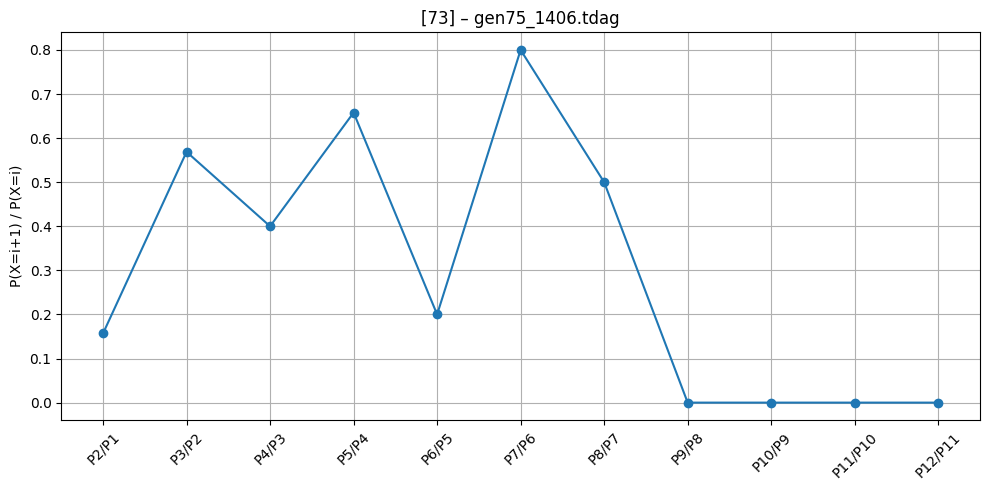

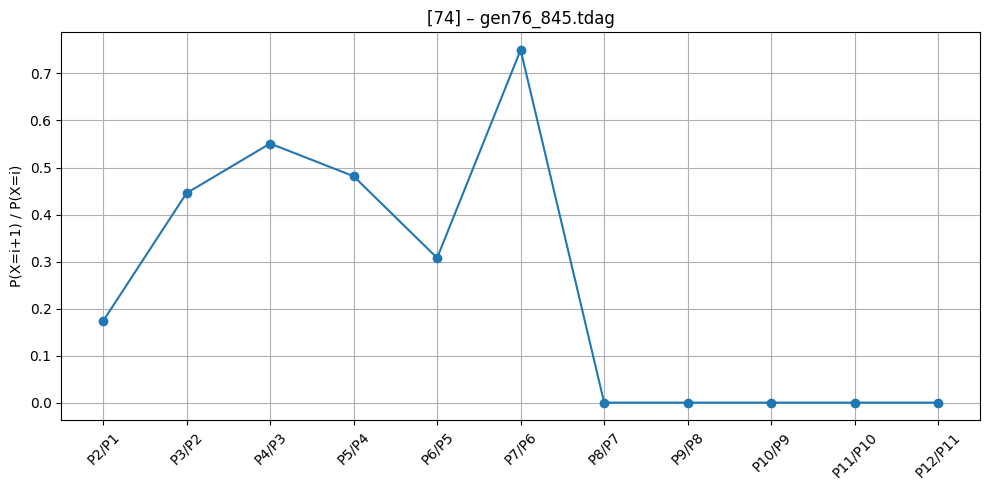

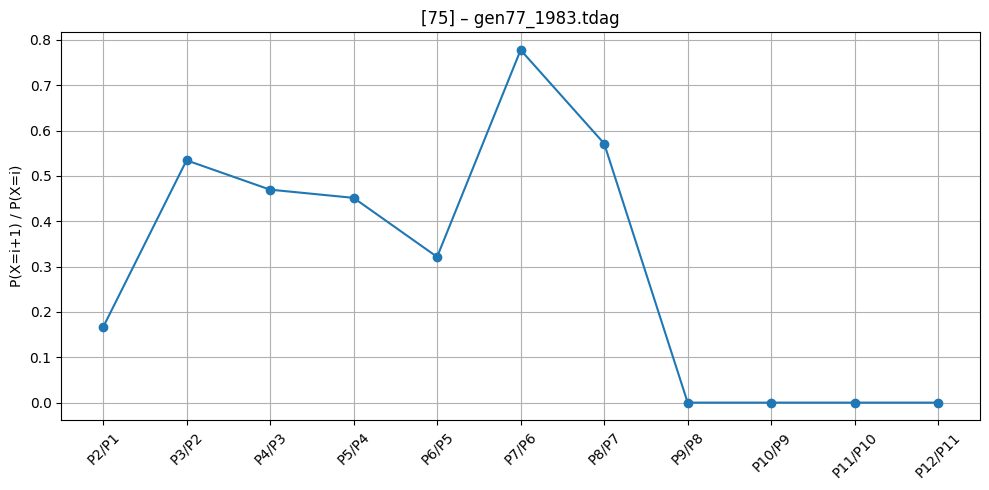

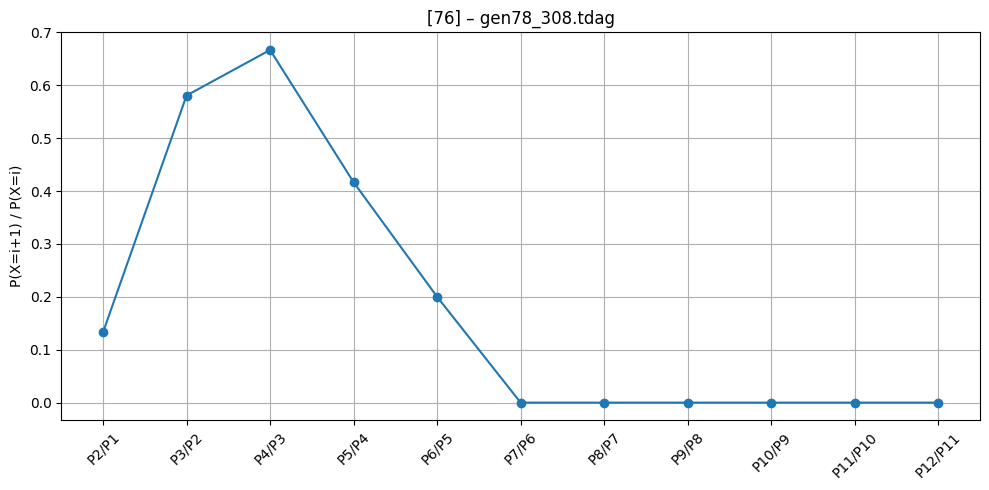

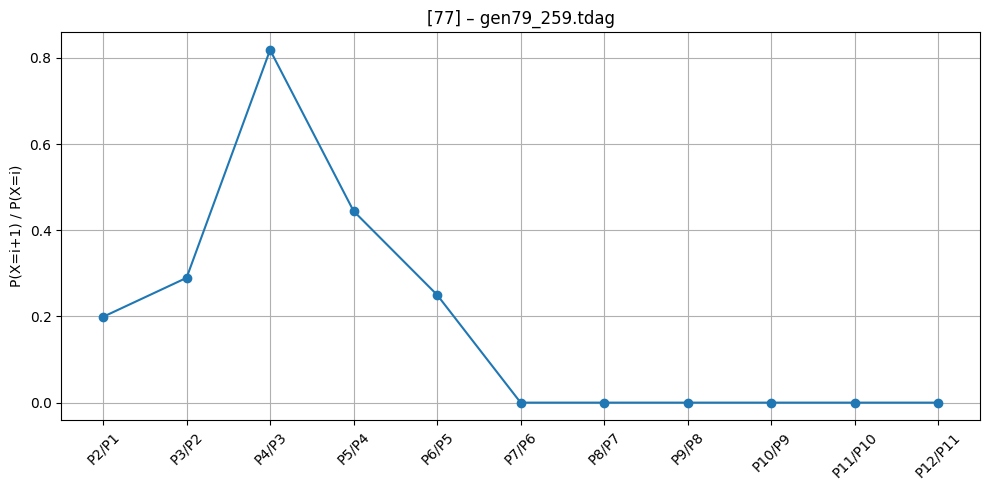

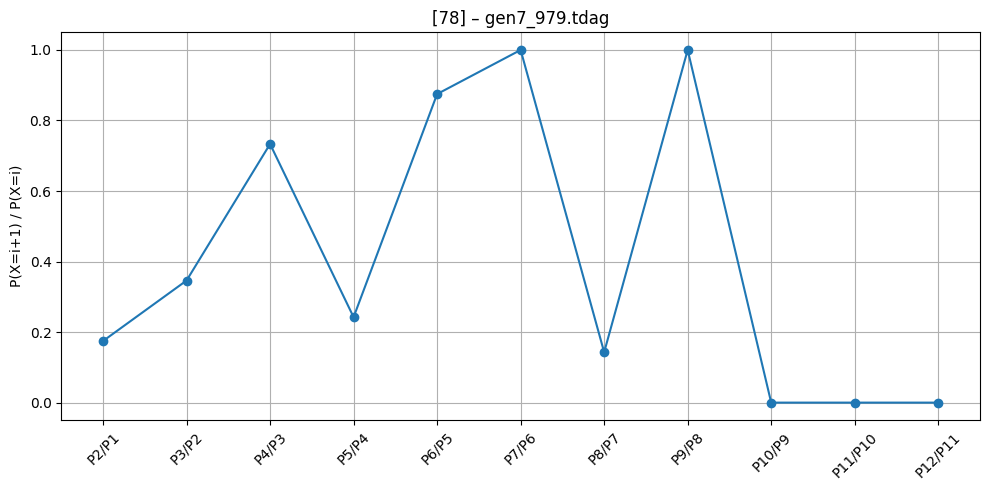

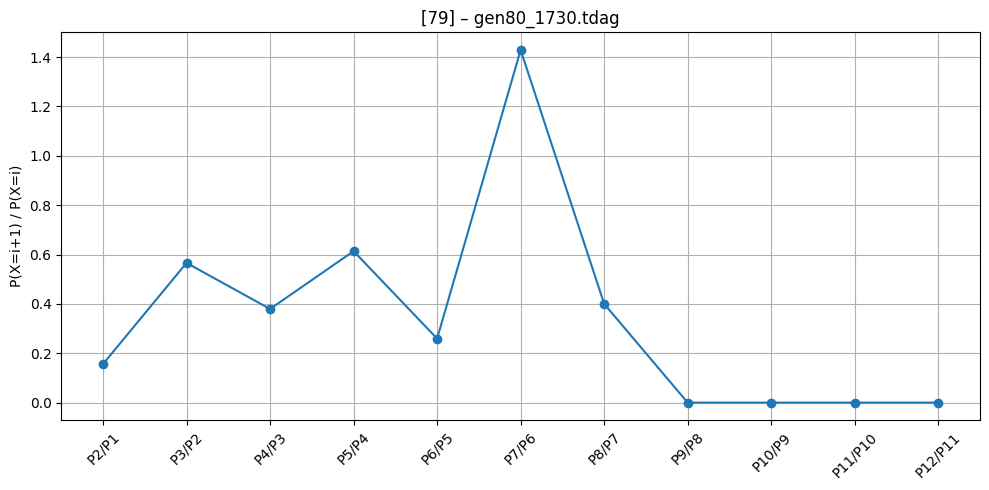

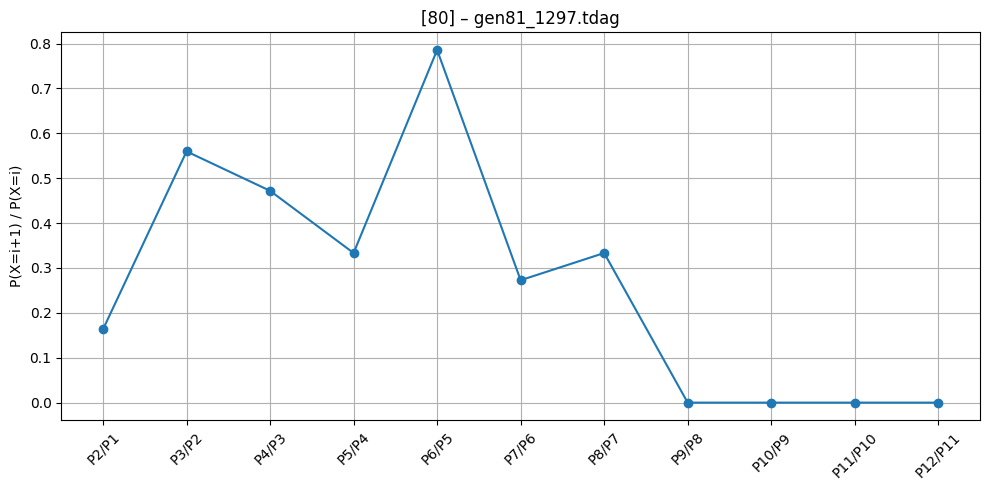

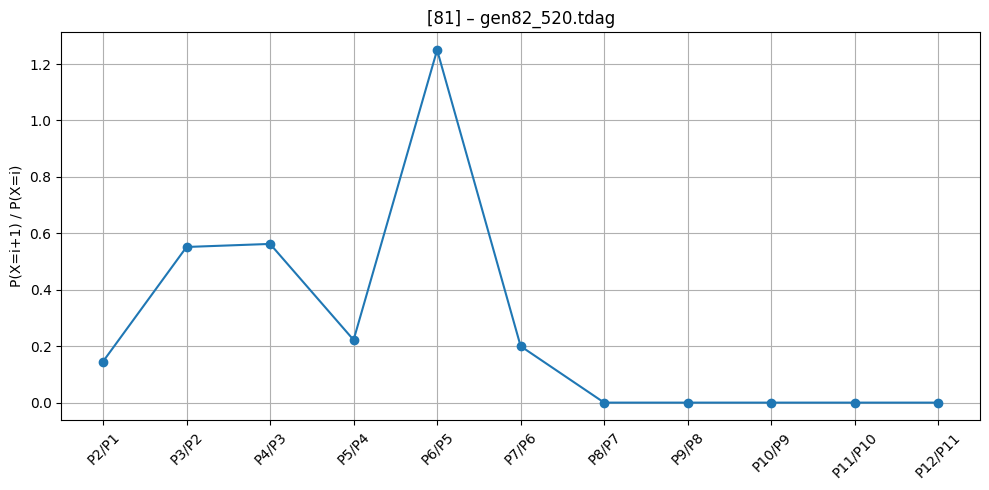

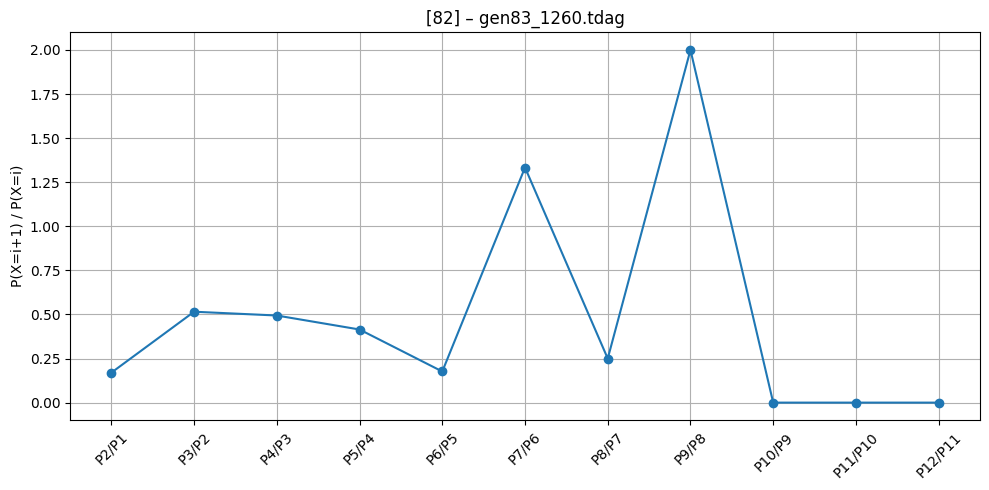

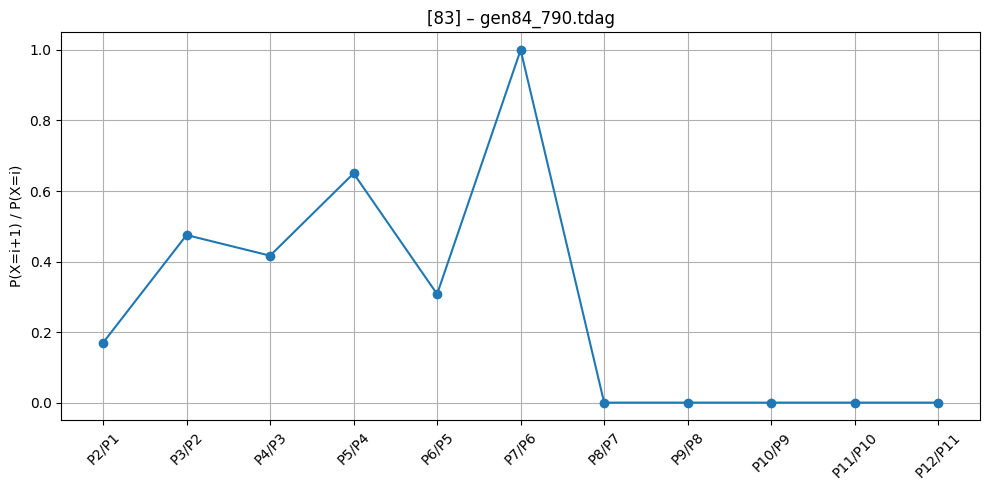

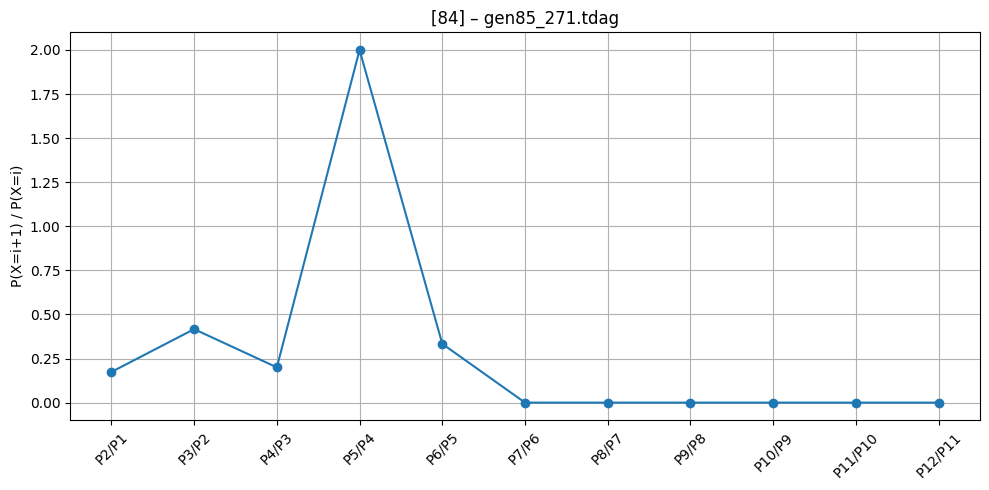

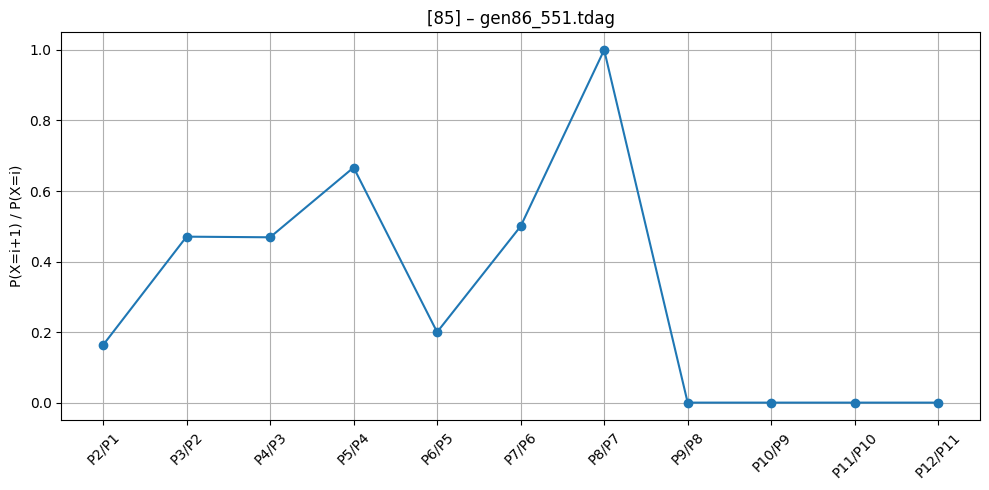

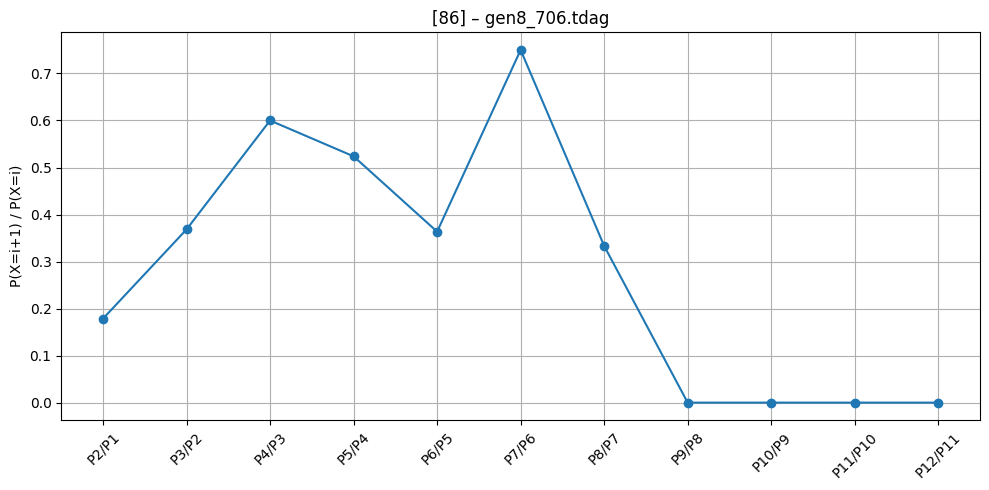

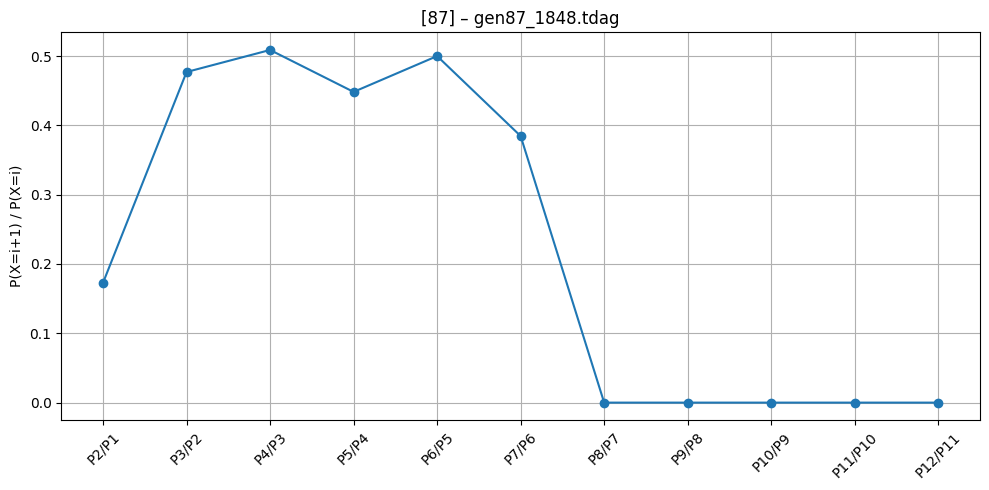

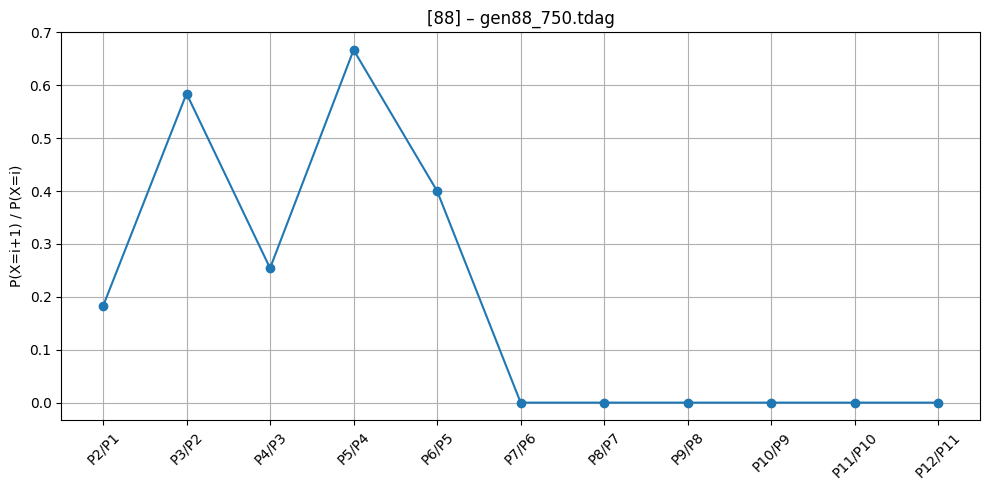

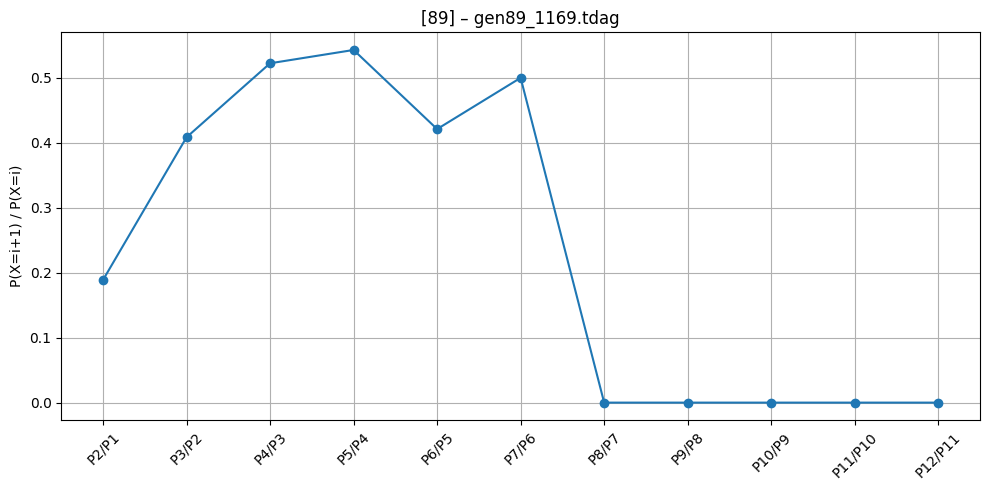

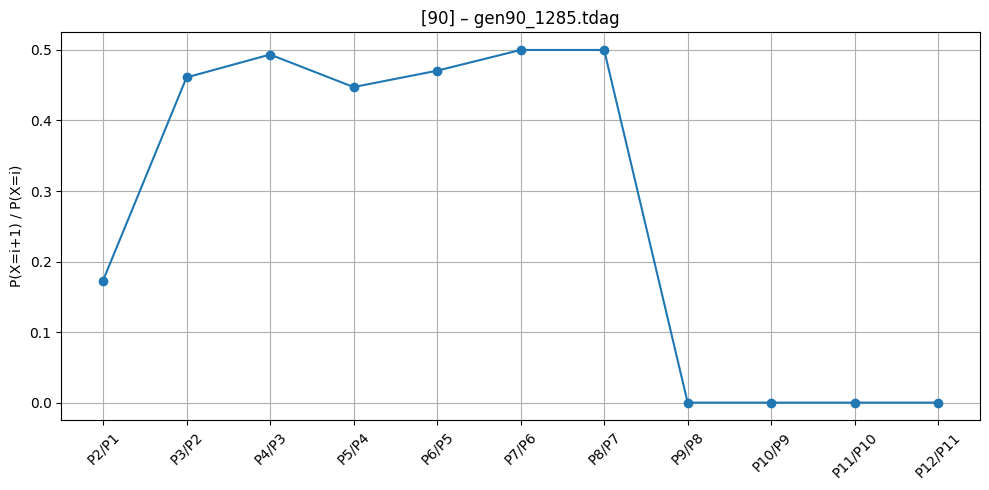

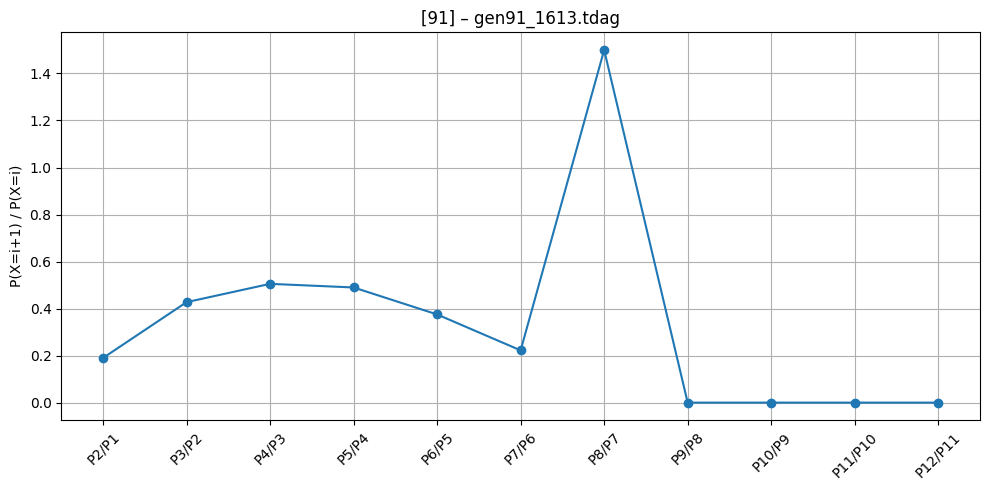

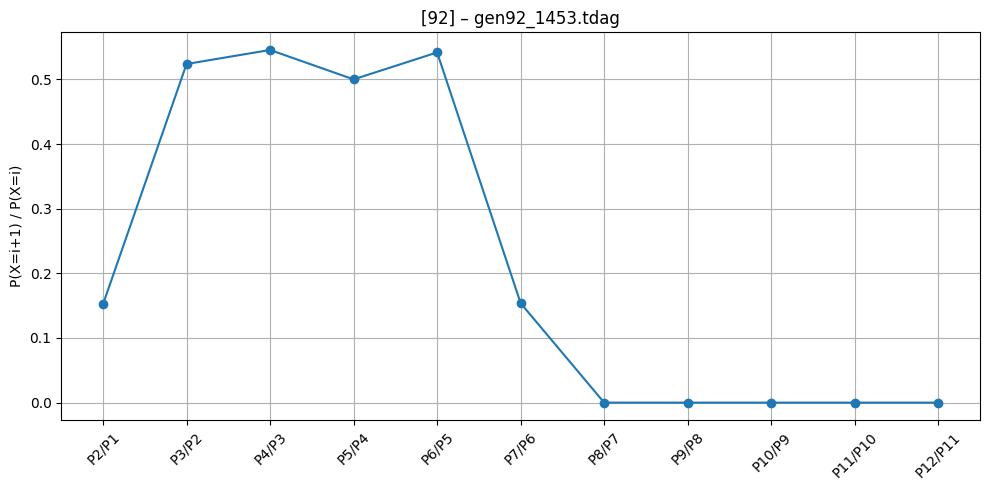

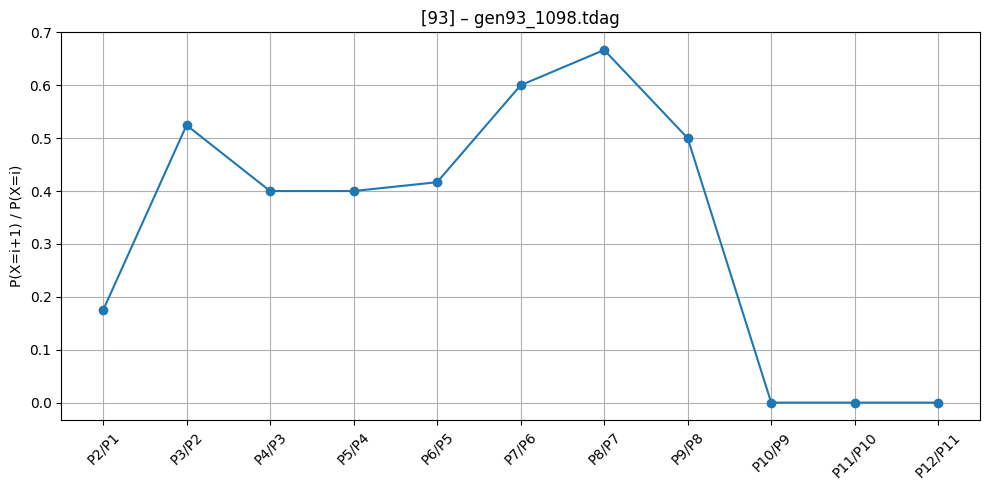

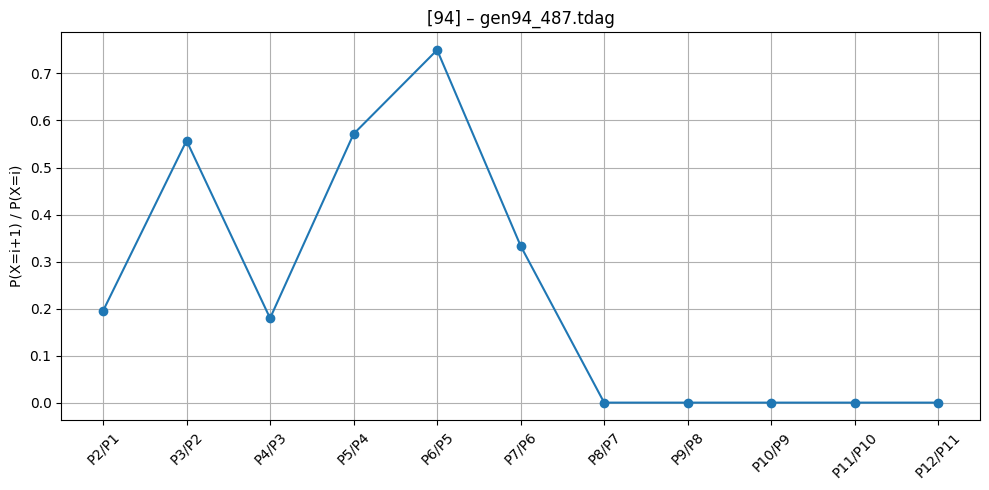

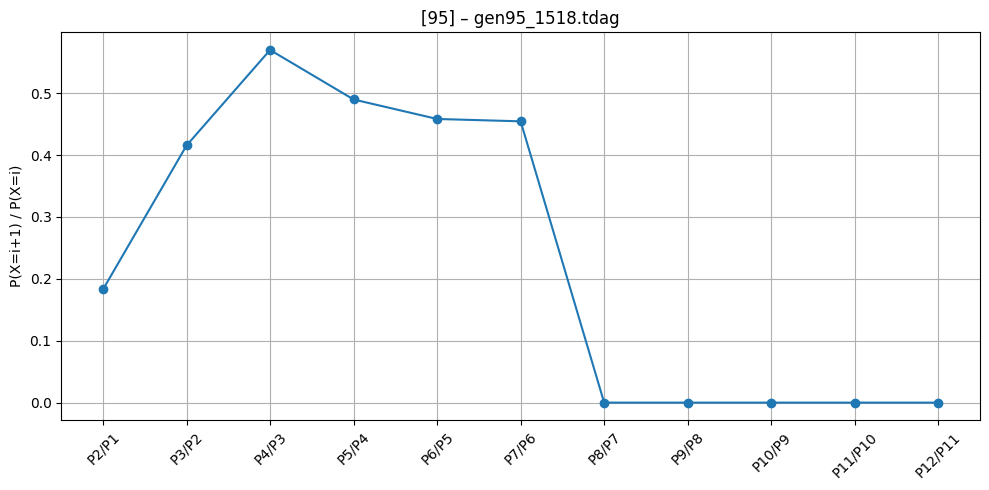

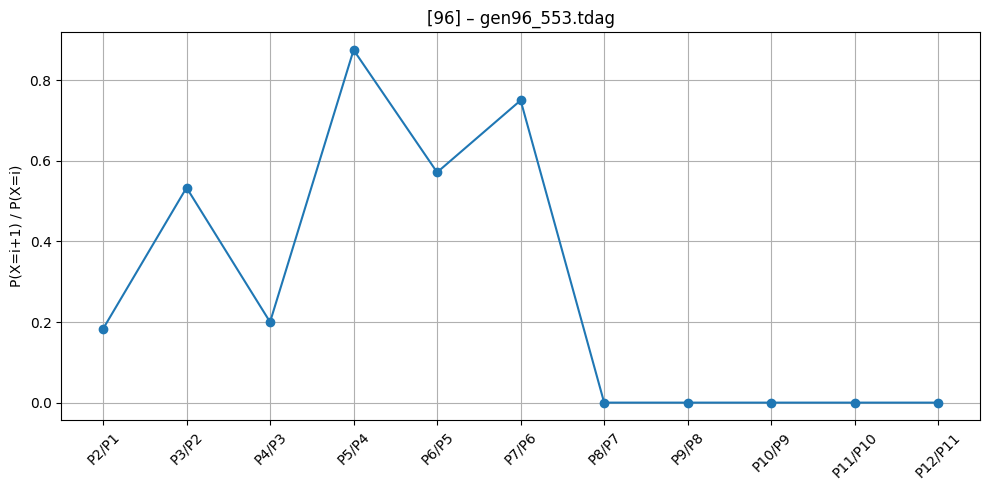

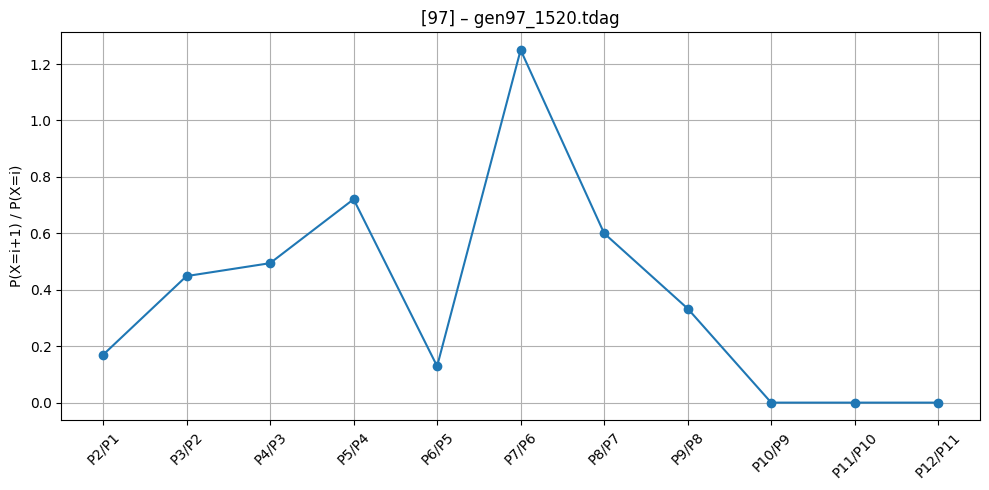

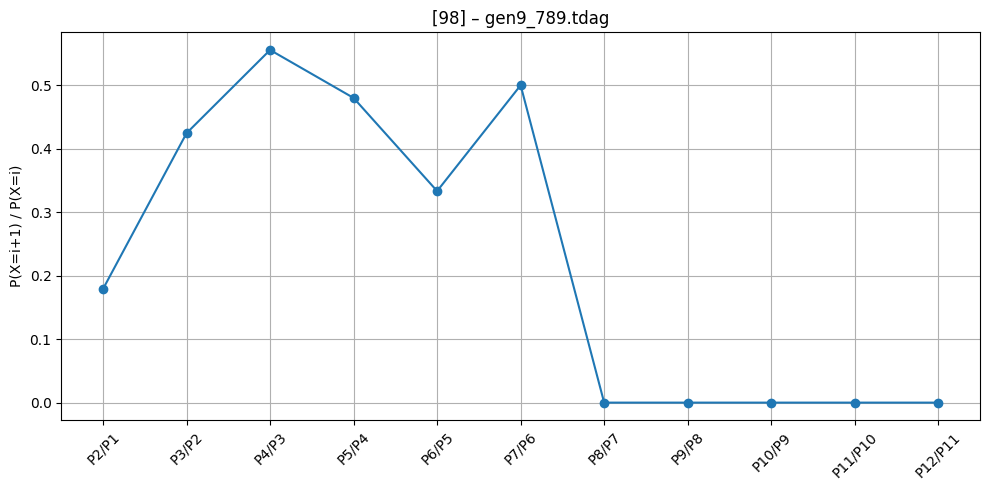

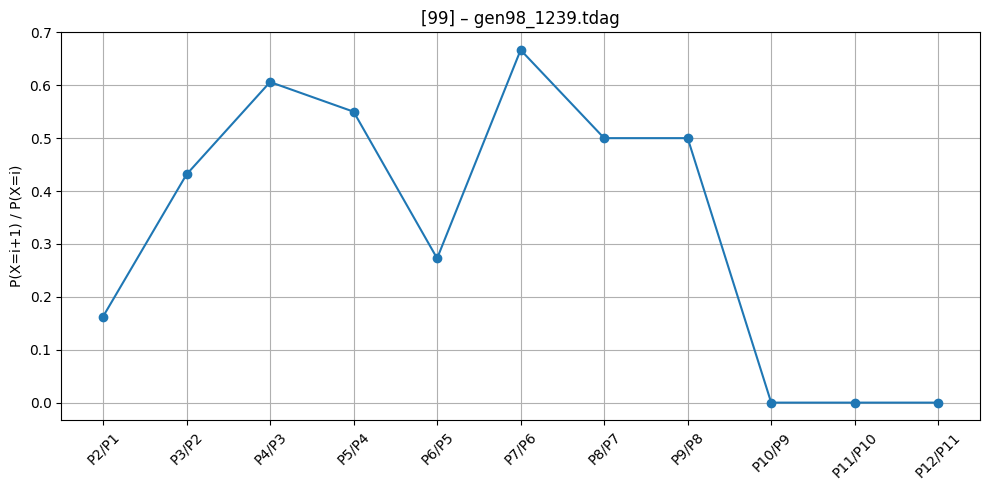

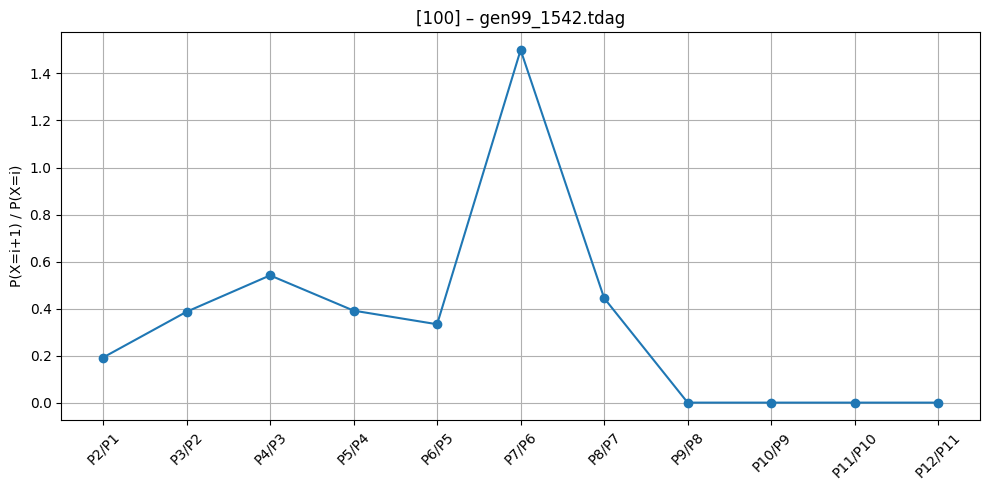

In [40]:
# ATTENTION : prend 1 à 2 minutes pour s'afficher

plot_ratios(df_enf, cols)

Contrairement aux graphes de Git, on n'observe pas de groupes de ratios constants. Au mieux, on a quelques ratios constants mais pas assez pour que cela suggère une loi géométrique sur les fréquences de noeuds.

Pour conclure sur la structure, les proportions de noeuds à $e$ enfants suivent à peu près celles obtenues sur les graphes de Git. Cependant, les proportions sur les parents sont éloignées de la réalité et en plus, il n'y a pas de loi géométrique sur les fréquences de noeuds à $e$e enfants. Ainsi, le modèle semble déjà trop diverger de nos graphes.

## 3. Largeur des graphes

### a. Evolution de la largeur

### b. Largeur maximale et bornes

## 4. Conclusion